# & Pridictive model for Term Deposit Marketing &

## Our primary goal:
* #### Build a predictive model that determines whether a customer will subscribe to a term deposit (y = yes/no).
## Business Goal:
* #### Identify customer segments most likely to subscribe (for targeting).
## Interpretability Goal:
* #### Find out which features matter most for decision-making (e.g., job, marital status, housing loan, etc.).
## Success Metric:
* #### Achieve at least 81% accuracy (using 5-fold cross-validation) and report the average performance score.

# Step 0: Environment & Imports

In [2]:
# Imports and reproducibility
import os, sys, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, roc_auc_score,
                             average_precision_score, classification_report, confusion_matrix,
                             precision_recall_curve, f1_score, brier_score_loss)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.calibration import CalibratedClassifierCV

RSEED = 42
np.random.seed(RSEED)

# XGBoost import with graceful fallback
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception as e:
    print("xgboost not available; will fallback to GradientBoostingClassifier. Install with: pip install xgboost")
    from sklearn.ensemble import GradientBoostingClassifier
    HAVE_XGB = False

pd.set_option("display.max_columns", 200)

In [5]:
# step 1: load the data 
df = pd.read_csv("Term-deposit-2020.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
# step 2: Target encoding and leakage prevention
assert 'y' in df.columns, "Expected target column 'y' not found."
y = df['y'].astype(str).str.lower().map({'yes':1, 'no':0}).astype(int)

# Pre-contact features: drop known post-call info: 'duration'
drop_cols = [c for c in ['duration'] if c in df.columns]
X = df.drop(columns=['y'] + drop_cols).copy()

print(f"Dropped columns (for leakage safety): {drop_cols}")
print("Class distribution (overall):")
print(y.value_counts(normalize=True).rename({0:'no',1:'yes'}).round(3))

# Quick null/duplicate scan (we'll impute later in the pipeline)
print("Nulls per column (top 10):")
print(X.isnull().sum().sort_values(ascending=False).head(10))
print("Duplicates:", df.duplicated().sum())


Dropped columns (for leakage safety): ['duration']
Class distribution (overall):
y
no     0.928
yes    0.072
Name: proportion, dtype: float64
Nulls per column (top 10):
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
dtype: int64
Duplicates: 0


## Step 3: preprocessing 

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RSEED
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train positive rate:", y_train.mean().round(4))
print(" Test positive rate:", y_test.mean().round(4))


Train size: (32000, 12)  Test size: (8000, 12)
Train positive rate: 0.0724
 Test positive rate: 0.0724


In [9]:
# step 4: Preprocessing pipelines
num_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number)]
cat_cols = [c for c in X_train.columns if c not in num_cols]

ohe_kwargs = dict(handle_unknown="ignore")
try:
    ohe = OneHotEncoder(sparse_output=False, **ohe_kwargs)
except TypeError:
    ohe = OneHotEncoder(sparse=False, **ohe_kwargs)

preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline(steps=[
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols),
])

## Step 5 : XGBoost with auto scale_pos_weight

In [10]:
# A thin wrapper that sets scale_pos_weight from y in each fit (CV-safe)
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class XGBWithAutoSPW(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self._clf_ = None

    def fit(self, X, y):
        y = np.asarray(y)
        pos = np.sum(y == 1)
        neg = np.sum(y == 0)
        spw = (neg / max(pos, 1)) if pos > 0 else 1.0
        params = dict(self.xgb_params)  # copy
        # Set robust defaults if missing
        params.setdefault("n_estimators", 500)
        params.setdefault("learning_rate", 0.05)
        params.setdefault("max_depth", 4)
        params.setdefault("subsample", 0.8)
        params.setdefault("colsample_bytree", 0.8)
        params.setdefault("reg_lambda", 1.0)
        params.setdefault("random_state", RSEED)
        params.setdefault("eval_metric", "logloss")
        params["scale_pos_weight"] = params.get("scale_pos_weight", spw)

        self._clf_ = XGBClassifier(**params) if HAVE_XGB else GradientBoostingClassifier(random_state=RSEED)
        # NOTE: For GradientBoosting fallback, scale_pos_weight is ignored.
        self._clf_.fit(X, y)
        return self

    def predict(self, X):
        return self._clf_.predict(X)

    def predict_proba(self, X):
        # XGB & GB both expose predict_proba
        return self._clf_.predict_proba(X)

    def get_params(self, deep=True):
        return dict(self.xgb_params)

    def set_params(self, **params):
        self.xgb_params.update(params)
        return self

## Step 6 : Pipeline + CV & Search

In [13]:
# Build pipeline and search space
from scipy.stats import loguniform, randint

clf = XGBWithAutoSPW(
    n_estimators=500,           # will be tuned
    learning_rate=0.05,         # will be tuned
    max_depth=4,                # will be tuned
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RSEED,
)

pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("clf", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "f1_macro": "f1_macro",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "balanced_acc": "balanced_accuracy",
    "neg_brier": "neg_brier_score",
}

# Reasonable space for XGB; for GB fallback, only n_estimators is relevant
param_distributions = {
    "clf__n_estimators": randint(200, 800),
    "clf__learning_rate": loguniform(1e-2, 3e-1),
    "clf__max_depth": randint(2, 7),
    "clf__reg_lambda": loguniform(1e-2, 10),
    # subsample/colsample can be tuned too, but keep the space compact initially:
    "clf__subsample": loguniform(0.6, 1.0),
    "clf__colsample_bytree": loguniform(0.6, 1.0),
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=RSEED,
    refit=True
)

search.fit(X_train, y_train)
print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)

Best CV accuracy: 0.8765000000000001
Best params: {'clf__colsample_bytree': np.float64(0.6876006599131045), 'clf__learning_rate': np.float64(0.2770631126298885), 'clf__max_depth': 5, 'clf__n_estimators': 765, 'clf__reg_lambda': np.float64(0.012564702171144132), 'clf__subsample': np.float64(0.7156569204425723)}


## Step 7 : Fit on train, evaluate on test, threshold tuning for high precision

In [14]:
# Cell 7: Multi-metric CV report on the best estimator
best_model = search.best_estimator_
cv_out = cross_validate(best_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

def summarize_cv(out):
    lines = []
    for k, v in out.items():
        if not k.startswith("test_"): 
            continue
        m = np.mean(v); s = np.std(v)
        lines.append((k[5:], m, s))
    return pd.DataFrame(lines, columns=["metric", "mean", "std"]).sort_values("metric")

cv_summary = summarize_cv(cv_out)
cv_summary


,metric,mean,std
0,accuracy,0.876500,0.002132
7,balanced_acc,0.575709,0.010457
1,f1,0.207824,0.017524
2,f1_macro,0.570426,0.009113
8,neg_brier,NaN,NaN
6,pr_auc,NaN,NaN
3,precision,0.193917,0.014763
4,recall,0.223984,0.021203
5,roc_auc,NaN,NaN


In [15]:
# step 8: Held-out test performance @ default 0.5 + threshold tuning
PRECISION_TARGET = 0.85  # adjust to your "high precision" goal

best_model.fit(X_train, y_train)
proba_test = best_model.predict_proba(X_test)[:, 1]
pred_05 = (proba_test >= 0.5).astype(int)

test_metrics = {
    "accuracy": accuracy_score(y_test, pred_05),
    "balanced_acc": balanced_accuracy_score(y_test, pred_05),
    "roc_auc": roc_auc_score(y_test, proba_test),
    "pr_auc": average_precision_score(y_test, proba_test),
}
print("=== Test metrics at threshold=0.50 ===")
for k,v in test_metrics.items():
    print(f"{k:>13}: {v:.4f}")

print("\nConfusion matrix @0.50:\n", confusion_matrix(y_test, pred_05))
print("\nClassification report @0.50:\n", classification_report(y_test, pred_05, target_names=["no","yes"]))

# Precision-Recall curve -> candidate thresholds
prec, rec, thr = precision_recall_curve(y_test, proba_test)
thr = np.r_[0, thr]  # align lengths

f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix_f1 = np.nanargmax(f1)
ix_pX = np.where(prec >= PRECISION_TARGET)[0]
ix_pX = ix_pX[np.argmax(rec[ix_pX])] if len(ix_pX) else ix_f1
ix_rec = np.argmax(rec)

def row(ix, name):
    t = float(thr[ix])
    p = float(prec[ix]); r = float(rec[ix]); f = float(f1[ix])
    yhat = (proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    return dict(
        operating_point=name, threshold=t, precision=p, recall=r, f1=f,
        predicted_positives=int(yhat.sum()), tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )

th_table = pd.DataFrame([
    row(ix_f1, f"max F1 ({f1[ix_f1]:.3f})"),
    row(ix_pX, f"precision ≥ {PRECISION_TARGET:.2f}"),
    row(ix_rec, "max recall"),
    row(np.argmin(np.abs(thr-0.5)), "threshold=0.50 (ref)")
]).sort_values("operating_point").reset_index(drop=True)

print("\n=== Threshold candidates (choose based on ops constraints) ===")
th_table

=== Test metrics at threshold=0.50 ===
     accuracy: 0.8722
 balanced_acc: 0.6055
      roc_auc: 0.6601
       pr_auc: 0.1968

Confusion matrix @0.50:
 [[6808  613]
 [ 409  170]]

Classification report @0.50:
               precision    recall  f1-score   support

          no       0.94      0.92      0.93      7421
         yes       0.22      0.29      0.25       579

    accuracy                           0.87      8000
   macro avg       0.58      0.61      0.59      8000
weighted avg       0.89      0.87      0.88      8000


=== Threshold candidates (choose based on ops constraints) ===


,operating_point,threshold,precision,recall,f1,predicted_positives,tp,fp,fn,tn
0,max F1 (0.260),0.583142,0.255426,0.264249,0.259762,600,153,447,426,6974
1,max recall,0.000000,0.072375,1.000000,0.134981,8000,579,7421,0,0
2,precision ≥ 0.85,0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420
3,threshold=0.50 (ref),0.499828,0.217114,0.293610,0.249633,784,170,614,409,6807


#### We are missing a lot of subscribers we need a better percision

In [17]:
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score

PRECISION_TARGETS = [0.90, 0.85, 0.80, 0.75]   

prec, rec, thr = precision_recall_curve(y_test, proba_test)
thr = np.r_[0, thr]  # align

f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix_f1   = int(np.nanargmax(f1))
ix_rec  = int(np.argmax(rec))

rows = []

# helper to collect a row
def make_row(ix, label):
    t = float(thr[ix])
    yhat = (proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    rows.append({
        "operating_point": label,
        "threshold": t,
        "precision": float(prec[ix]),
        "recall": float(rec[ix]),
        "f1": float(f1[ix]),
        "predicted_positives": int(yhat.sum()),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "accuracy": float(accuracy_score(y_test, yhat)),
        "balanced_acc": float(balanced_accuracy_score(y_test, yhat)),
    })

# max-F1 and max-recall references
make_row(ix_f1,  f"max F1 ({f1[ix_f1]:.3f})")
make_row(ix_rec, "max recall")

# best recall subject to precision >= target
for pt in PRECISION_TARGETS:
    ok = np.where(prec >= pt)[0]
    if len(ok):
        ix = int(ok[np.argmax(rec[ok])])
        make_row(ix, f"precision ≥ {pt:.2f} (max recall)")
    else:
        rows.append({"operating_point": f"precision ≥ {pt:.2f} (unattainable on test)", "threshold": np.nan})

th_candidates = pd.DataFrame(rows).drop_duplicates(subset=["operating_point"]).reset_index(drop=True)
th_candidates

,operating_point,threshold,precision,recall,f1,predicted_positives,TP,FP,FN,TN,accuracy,balanced_acc
0,max F1 (0.260),0.583142,0.255426,0.264249,0.259762,600,153,447,426,6974,0.890875,0.602007
1,max recall,0.000000,0.072375,1.000000,0.134981,8000,579,7421,0,0,0.072375,0.500000
2,precision ≥ 0.90 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
3,precision ≥ 0.85 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
4,precision ≥ 0.80 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
5,precision ≥ 0.75 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796


In [18]:
# Expand precision targets to get usable recall right now
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, balanced_accuracy_score

PRECISION_TARGETS = [0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50]

prec, rec, thr = precision_recall_curve(y_test, proba_test)
thr = np.r_[0, thr]
f1 = 2 * prec * rec / (prec + rec + 1e-12)

rows = []
def add_row(ix, label):
    t = float(thr[ix]); yhat=(proba_test>=t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    rows.append({
        "operating_point": label, "threshold": t,
        "precision": float(prec[ix]), "recall": float(rec[ix]), "f1": float(f1[ix]),
        "predicted_positives": int(yhat.sum()), "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "accuracy": float(accuracy_score(y_test, yhat)),
        "balanced_acc": float(balanced_accuracy_score(y_test, yhat)),
    })

ix_f1, ix_rec = int(np.nanargmax(f1)), int(np.argmax(rec))
add_row(ix_f1,  f"max F1 ({f1[ix_f1]:.3f})")
add_row(ix_rec, "max recall")

for pt in PRECISION_TARGETS:
    ok = np.where(prec >= pt)[0]
    if len(ok):
        ix = int(ok[np.argmax(rec[ok])])     # highest recall at that precision
        add_row(ix, f"precision ≥ {pt:.2f} (max recall)")
    else:
        rows.append({"operating_point": f"precision ≥ {pt:.2f} (unattainable on test)", "threshold": np.nan})

th_candidates = pd.DataFrame(rows).drop_duplicates("operating_point").reset_index(drop=True)
th_candidates.sort_values(["precision","recall"], ascending=[False, False])

,operating_point,threshold,precision,recall,f1,predicted_positives,TP,FP,FN,TN,accuracy,balanced_acc
2,precision ≥ 0.90 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
3,precision ≥ 0.85 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
4,precision ≥ 0.80 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
5,precision ≥ 0.75 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
6,precision ≥ 0.70 (max recall),0.999287,1.000000,0.001727,0.003448,2,1,1,578,7420,0.927625,0.500796
7,precision ≥ 0.65 (max recall),0.998413,0.666667,0.003454,0.006873,4,2,2,577,7419,0.927625,0.501592
8,precision ≥ 0.60 (max recall),0.987534,0.625000,0.017271,0.033613,17,10,7,569,7414,0.928000,0.508164
9,precision ≥ 0.55 (max recall),0.951072,0.555556,0.069085,0.122888,73,40,33,539,7388,0.928500,0.532319
10,precision ≥ 0.50 (max recall),0.921551,0.500000,0.091537,0.154745,107,53,54,526,7367,0.927500,0.542130
0,max F1 (0.260),0.583142,0.255426,0.264249,0.259762,600,153,447,426,6974,0.890875,0.602007


In [31]:
#  scale_pos_weight multiplier grid (kept compact)
from sklearn.model_selection import StratifiedKFold, cross_validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class XGBWithSPWMultiplier(XGBWithAutoSPW):
    def __init__(self, spw_multiplier=1.0, **xgb_params):
        super().__init__(**xgb_params)
        self.spw_multiplier = spw_multiplier
    def fit(self, X, y):
        y = np.asarray(y); pos=(y==1).sum(); neg=(y==0).sum()
        base = (neg / max(pos,1)) if pos>0 else 1.0
        params = dict(self.xgb_params)
        params["scale_pos_weight"] = base * self.spw_multiplier
        params.setdefault("n_estimators", 600)
        params.setdefault("learning_rate", 0.05)
        params.setdefault("max_depth", 4)
        params.setdefault("subsample", 0.8)
        params.setdefault("colsample_bytree", 0.8)
        params.setdefault("reg_lambda", 1.0)
        params.setdefault("random_state", 42)
        params.setdefault("eval_metric", "logloss")
        self._clf_ = XGBClassifier(**params) if HAVE_XGB else GradientBoostingClassifier(random_state=42)
        self._clf_.fit(X, y)
        return self

rows=[]
for mult in [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    pipe_m = Pipeline([("pre", best_model.named_steps["pre"]),
                       ("clf", XGBWithSPWMultiplier(spw_multiplier=mult))])
    out = cross_validate(pipe_m, X_train, y_train, cv=cv,
                         scoring={"pr_auc":"average_precision","roc_auc":"roc_auc","accuracy":"accuracy"},
                         n_jobs=-1)
    rows.append({"spw_multiplier": mult,
                 "cv_pr_auc": out["test_pr_auc"].mean(),
                 "cv_roc_auc": out["test_roc_auc"].mean(),
                 "cv_accuracy": out["test_accuracy"].mean()})
spw_table = pd.DataFrame(rows).sort_values(["cv_pr_auc","cv_accuracy"], ascending=[False, False])
spw_table


,spw_multiplier,cv_pr_auc,cv_roc_auc,cv_accuracy
0,0.50,NaN,NaN,0.770375
1,0.75,NaN,NaN,0.770375
2,1.00,NaN,NaN,0.770375
3,1.25,NaN,NaN,0.770375
4,1.50,NaN,NaN,0.770375
5,2.00,NaN,NaN,0.770375


In [21]:
# Verify underlying model + fold class counts
from sklearn.model_selection import StratifiedKFold

# 1) What classifier is actually inside our best_model?
try:
    print("Best pipeline steps:", list(best_model.named_steps.keys()))
    inner = best_model.named_steps.get("clf", None)
    print("Inner estimator wrapper:", type(inner))
    if hasattr(inner, "_clf_") and inner._clf_ is not None:
        print("Underlying fitted classifier:", type(inner._clf_))
    else:
        print("Underlying fitted classifier not yet set — will appear after .fit()")
except Exception as e:
    print("Introspection error:", e)

# 2) Confirm each fold has positives (should be true with StratifiedKFold)
cv_dbg = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pos_counts = []
for train_idx, valid_idx in cv_dbg.split(X_train, y_train):
    pos_counts.append(int(y_train.iloc[valid_idx].sum()))
print("Positives per validation fold:", pos_counts, " | total val size per fold:", len(valid_idx))

Best pipeline steps: ['pre', 'clf']
Inner estimator wrapper: <class '__main__.XGBWithAutoSPW'>
Underlying fitted classifier: <class 'xgboost.sklearn.XGBClassifier'>
Positives per validation fold: [463, 463, 463, 464, 464]  | total val size per fold: 6400


In [22]:
# Calibrate and rebuild threshold candidates
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (brier_score_loss, average_precision_score, precision_recall_curve,
                             confusion_matrix, accuracy_score, balanced_accuracy_score)
import numpy as np, pandas as pd

cal = CalibratedClassifierCV(best_model, cv=5, method="isotonic")
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:,1]

print("Brier uncalibrated:", brier_score_loss(y_test, proba_test).round(4))
print("Brier calibrated  :", brier_score_loss(y_test, proba_cal).round(4))
print("PR AUC uncal      :", average_precision_score(y_test, proba_test).round(4))
print("PR AUC cal        :", average_precision_score(y_test, proba_cal).round(4))

# Build calibrated threshold table with practical precision targets
PRECISION_TARGETS = [0.90,0.85,0.80,0.75,0.70,0.65,0.60,0.55,0.50]
prec, rec, thr = precision_recall_curve(y_test, proba_cal)
thr = np.r_[0, thr]
f1 = 2 * prec * rec / (prec + rec + 1e-12)

rows=[]
def add_row(ix, label):
    t=float(thr[ix]); yhat=(proba_cal>=t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    rows.append({"operating_point": label, "threshold": t,
                 "precision": float(prec[ix]), "recall": float(rec[ix]), "f1": float(f1[ix]),
                 "predicted_positives": int(yhat.sum()), "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
                 "accuracy": float(accuracy_score(y_test, yhat)),
                 "balanced_acc": float(balanced_accuracy_score(y_test, yhat))})

ix_f1, ix_rec = int(np.nanargmax(f1)), int(np.argmax(rec))
add_row(ix_f1,  f"max F1 ({f1[ix_f1]:.3f})")
add_row(ix_rec, "max recall")

for pt in PRECISION_TARGETS:
    ok = np.where(prec >= pt)[0]
    if len(ok):
        ix = int(ok[np.argmax(rec[ok])])
        add_row(ix, f"precision ≥ {pt:.2f} (max recall)")
    else:
        rows.append({"operating_point": f"precision ≥ {pt:.2f} (unattainable on test)", "threshold": np.nan})

th_candidates_cal = pd.DataFrame(rows).drop_duplicates("operating_point").reset_index(drop=True)
th_candidates_cal.sort_values(["precision","recall"], ascending=[False, False])

ValueError: Pipeline should either be a classifier to be used with response_method=['decision_function', 'predict_proba'] or the response_method should be 'predict'. Got a regressor with response_method=['decision_function', 'predict_proba'] instead.

In [23]:
# Re-define the wrapper with classifier metadata
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBWithAutoSPW_Patched(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"  # <-- crucial

    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self._clf_ = None
        self.classes_ = None

    def fit(self, X, y):
        y = np.asarray(y)
        pos = (y==1).sum(); neg = (y==0).sum()
        spw = (neg / max(pos,1)) if pos>0 else 1.0
        params = dict(self.xgb_params)
        params.setdefault("n_estimators", 500)
        params.setdefault("learning_rate", 0.05)
        params.setdefault("max_depth", 4)
        params.setdefault("subsample", 0.8)
        params.setdefault("colsample_bytree", 0.8)
        params.setdefault("reg_lambda", 1.0)
        params.setdefault("random_state", 42)
        params.setdefault("eval_metric", "logloss")
        params["scale_pos_weight"] = params.get("scale_pos_weight", spw)

        from xgboost import XGBClassifier
        self._clf_ = XGBClassifier(**params)
        self._clf_.fit(X, y)
        self.classes_ = getattr(self._clf_, "classes_", np.array([0,1]))
        return self

    def predict(self, X):
        return self._clf_.predict(X)

    def predict_proba(self, X):
        return self._clf_.predict_proba(X)

    def get_params(self, deep=True):
        return dict(self.xgb_params)

    def set_params(self, **params):
        self.xgb_params.update(params)
        return self

# Rebuild the pipeline using the same preprocessor and XGB params from the old wrapper
old = best_model.named_steps["clf"]
new_clf = XGBWithAutoSPW_Patched(**old.xgb_params)

from sklearn.pipeline import Pipeline
best_model = Pipeline([("pre", best_model.named_steps["pre"]), ("clf", new_clf)])
_ = best_model.fit(X_train, y_train)
print("Rebuilt pipeline with patched wrapper.")

Rebuilt pipeline with patched wrapper.


In [25]:
# Make the wrapper in the existing pipeline explicitly a classifier
best_model.named_steps["clf"]._estimator_type = "classifier"

# Ensure classes_ is available (CalibratedClassifierCV sometimes checks this)
if not hasattr(best_model.named_steps["clf"], "classes_"):
    # If the pipeline is already fit, copy from the inner XGB; otherwise do a quick fit then copy
    try:
        best_model.named_steps["clf"].classes_ = best_model.named_steps["clf"]._clf_.classes_
    except Exception:
        _ = best_model.fit(X_train, y_train)
        best_model.named_steps["clf"].classes_ = best_model.named_steps["clf"]._clf_.classes_

print("Patched:", getattr(best_model.named_steps["clf"], "_estimator_type", None),
      "| classes_ set?", hasattr(best_model.named_steps["clf"], "classes_"))

Patched: classifier | classes_ set? True


In [27]:
# === B2-alt: Calibrate using a plain Pipeline that ends in a true XGBClassifier ===
import numpy as np, pandas as pd
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (brier_score_loss, average_precision_score, precision_recall_curve,
                             confusion_matrix, accuracy_score, balanced_accuracy_score)

# 1) Reuse your fitted preprocessor from best_model
pre = best_model.named_steps["pre"]

# 2) Pull XGB params from the wrapper if available; otherwise fall back to robust defaults
xgb_params = {}
if hasattr(best_model.named_steps["clf"], "xgb_params"):
    xgb_params = dict(best_model.named_steps["clf"].xgb_params)  # copy

# Fill robust defaults / ensure required keys
xgb_params.setdefault("n_estimators", 600)
xgb_params.setdefault("learning_rate", 0.05)
xgb_params.setdefault("max_depth", 4)
xgb_params.setdefault("subsample", 0.8)
xgb_params.setdefault("colsample_bytree", 0.8)
xgb_params.setdefault("reg_lambda", 1.0)
xgb_params["random_state"] = 42
xgb_params["eval_metric"] = "logloss"

# 3) Compute scale_pos_weight from *train* labels (constant during calibration CV)
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
xgb_params["scale_pos_weight"] = (neg / max(pos, 1)) if pos > 0 else 1.0

# 4) Build a calibration-friendly pipeline (no custom wrapper)
pipe_plain = Pipeline([
    ("pre", pre),
    ("clf", XGBClassifier(**xgb_params))
])

# Fit on train, get uncalibrated test scores for comparison
pipe_plain.fit(X_train, y_train)
proba_test_plain = pipe_plain.predict_proba(X_test)[:, 1]

# 5) Calibrate (isotonic) with 5-fold CV on the train split
cal = CalibratedClassifierCV(estimator=pipe_plain, cv=5, method="isotonic")
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:, 1]

print("Brier uncalibrated:", brier_score_loss(y_test, proba_test_plain).round(4))
print("Brier calibrated  :", brier_score_loss(y_test, proba_cal).round(4))
print("PR AUC uncal      :", average_precision_score(y_test, proba_test_plain).round(4))
print("PR AUC cal        :", average_precision_score(y_test, proba_cal).round(4))

# 6) Build a precision-first threshold table from *calibrated* scores
PRECISION_TARGETS = [0.90,0.85,0.80,0.75,0.70,0.65,0.60,0.55,0.50]
prec, rec, thr = precision_recall_curve(y_test, proba_cal)
thr = np.r_[0, thr]
f1  = 2 * prec * rec / (prec + rec + 1e-12)

rows = []
def add_row(ix, label):
    t = float(thr[ix]); yhat = (proba_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    rows.append({
        "operating_point": label, "threshold": t,
        "precision": float(prec[ix]), "recall": float(rec[ix]), "f1": float(f1[ix]),
        "predicted_positives": int(yhat.sum()), "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "accuracy": float(accuracy_score(y_test, yhat)),
        "balanced_acc": float(balanced_accuracy_score(y_test, yhat)),
    })

ix_f1, ix_rec = int(np.nanargmax(f1)), int(np.argmax(rec))
add_row(ix_f1,  f"max F1 ({f1[ix_f1]:.3f})")
add_row(ix_rec, "max recall")
for pt in PRECISION_TARGETS:
    ok = np.where(prec >= pt)[0]
    if len(ok):
        ix = int(ok[np.argmax(rec[ok])])  # highest recall at that precision
        add_row(ix, f"precision ≥ {pt:.2f} (max recall)")
    else:
        rows.append({"operating_point": f"precision ≥ {pt:.2f} (unattainable on test)", "threshold": np.nan})

th_candidates_cal = pd.DataFrame(rows).drop_duplicates("operating_point").reset_index(drop=True)
th_candidates_cal.sort_values(["precision","recall"], ascending=[False, False])

Brier uncalibrated: 0.099
Brier calibrated  : 0.0631
PR AUC uncal      : 0.1968
PR AUC cal        : 0.2201


,operating_point,threshold,precision,recall,f1,predicted_positives,TP,FP,FN,TN,accuracy,balanced_acc
2,precision ≥ 0.90 (max recall),0.565017,1.000000,0.003454,0.006885,3,2,1,577,7420,0.927750,0.501660
3,precision ≥ 0.85 (max recall),0.565017,1.000000,0.003454,0.006885,3,2,1,577,7420,0.927750,0.501660
4,precision ≥ 0.80 (max recall),0.565017,1.000000,0.003454,0.006885,3,2,1,577,7420,0.927750,0.501660
5,precision ≥ 0.75 (max recall),0.422315,0.750000,0.020725,0.040336,17,12,5,567,7416,0.928500,0.510026
6,precision ≥ 0.70 (max recall),0.338826,0.702703,0.044905,0.084416,38,26,12,553,7409,0.929375,0.521644
7,precision ≥ 0.65 (max recall),0.318779,0.652174,0.051813,0.096000,47,30,17,549,7404,0.929250,0.524761
8,precision ≥ 0.60 (max recall),0.305524,0.600000,0.056995,0.104101,56,33,23,546,7398,0.928875,0.526948
9,precision ≥ 0.55 (max recall),0.268566,0.550000,0.075993,0.133536,81,44,37,535,7384,0.928500,0.535504
10,precision ≥ 0.50 (max recall),0.229112,0.500000,0.101900,0.169297,119,59,60,520,7361,0.927500,0.546907
0,max F1 (0.272),0.101751,0.224972,0.345423,0.272480,890,200,690,379,6731,0.866375,0.626222


In [29]:
# Recompute & print test metrics for the locked operating point (precision ≥ 0.70)
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
)

# Use calibrated scores if available
try:
    scores = proba_final  # from earlier cell (calibrated)
except NameError:
    scores = cal.predict_proba(X_test)[:, 1]

yhat_sel = (scores >= THRESH_SELECTED).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, yhat_sel).ravel()
base_rate = y_test.mean()

acc   = accuracy_score(y_test, yhat_sel)
bacc  = balanced_accuracy_score(y_test, yhat_sel)
roc   = roc_auc_score(y_test, scores)
prauc = average_precision_score(y_test, scores)
prec  = precision_score(y_test, yhat_sel, zero_division=0)
rec   = recall_score(y_test, yhat_sel, zero_division=0)
f1    = f1_score(y_test, yhat_sel, zero_division=0)
spec  = tn / (tn + fp) if (tn + fp) > 0 else np.nan
lift  = (prec / base_rate) if base_rate > 0 else np.nan

print(f"=== Locked operating point @ threshold={THRESH_SELECTED:.6f} ===")
print("Confusion matrix:\n", np.array([[tn, fp],[fn, tp]]))
print("\nClassification report:\n", classification_report(y_test, yhat_sel, target_names=["no","yes"]))
print(f"Accuracy         : {acc:.4f}")
print(f"Balanced Acc     : {bacc:.4f}")
print(f"ROC AUC (scores) : {roc:.4f}")
print(f"PR  AUC (scores) : {prauc:.4f}")
print(f"Precision (PPV)  : {prec:.4f}")
print(f"Recall (TPR)     : {rec:.4f}")
print(f"Specificity (TNR): {spec:.4f}")
print(f"F1               : {f1:.4f}")
print(f"Base rate (yes)  : {base_rate:.4f}")
print(f"Lift vs base     : {lift:.2f}x")
print(f"Predicted +      : {int(yhat_sel.sum())} (TP={tp}, FP={fp})")


=== Locked operating point @ threshold=0.338826 ===
Confusion matrix:
 [[7409   12]
 [ 553   26]]

Classification report:
               precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.68      0.04      0.08       579

    accuracy                           0.93      8000
   macro avg       0.81      0.52      0.52      8000
weighted avg       0.91      0.93      0.90      8000

Accuracy         : 0.9294
Balanced Acc     : 0.5216
ROC AUC (scores) : 0.6761
PR  AUC (scores) : 0.2201
Precision (PPV)  : 0.6842
Recall (TPR)     : 0.0449
Specificity (TNR): 0.9984
F1               : 0.0843
Base rate (yes)  : 0.0724
Lift vs base     : 9.45x
Predicted +      : 38 (TP=26, FP=12)


#### still low but we will proceed to feature importance

## Feature importance and segmentation

In [32]:
# step 12: recover transformed feature names from the fitted preprocessor
import numpy as np, pandas as pd

pre = cal.estimator.named_steps["pre"]  # the plain pipeline we calibrated wraps this ColumnTransformer

# numeric feature names
num_names = list(pre.transformers_[0][2])

# categorical one-hot names
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
cat_raw = pre.transformers_[1][2]
try:
    cat_names = list(ohe.get_feature_names_out(cat_raw))
except TypeError:
    # older sklearn
    cat_names = list(ohe.get_feature_names(cat_raw))

feat_names = num_names + cat_names
print(f"{len(num_names)} numeric + {len(cat_names)} encoded categorical = {len(feat_names)} total features")


4 numeric + 39 encoded categorical = 43 total features


In [34]:
# step 13 (fixed): permutation importance in TRANSFORMED space (one score per one-hot feature)
from sklearn.inspection import permutation_importance
import numpy as np, pandas as pd

# 1) Get transformed matrix and the underlying XGB (calibration doesn't affect ranking for importance)
pre  = cal.estimator.named_steps["pre"]   # ColumnTransformer
xgb  = cal.estimator.named_steps["clf"]   # XGBClassifier trained on preprocessed features
Xt_test = pre.transform(X_test)           # numpy array

# 2) Compute permutation importance with AP (precision-first) and ROC-AUC scorers
r_ap  = permutation_importance(
    estimator=xgb, X=Xt_test, y=y_test,
    n_repeats=20, random_state=42, scoring="average_precision", n_jobs=-1
)
r_auc = permutation_importance(
    estimator=xgb, X=Xt_test, y=y_test,
    n_repeats=20, random_state=42, scoring="roc_auc", n_jobs=-1
)

# 3) Build the per-feature name list from step 12 (feat_names) and make the table
imp_df = pd.DataFrame({
    "feature": feat_names,                       # one per transformed column
    "imp_ap_mean":  r_ap.importances_mean,
    "imp_ap_std":   r_ap.importances_std,
    "imp_auc_mean": r_auc.importances_mean,
    "imp_auc_std":  r_auc.importances_std
}).sort_values("imp_ap_mean", ascending=False)

display(imp_df.head(25))


,feature,imp_ap_mean,imp_ap_std,imp_auc_mean,imp_auc_std
2,day,0.072563,0.005832,0.034027,0.007295
31,contact_unknown,0.036074,0.005072,0.028242,0.004411
37,month_jul,0.024921,0.004465,0.013089,0.002933
33,month_aug,0.024108,0.004842,0.022379,0.002965
29,contact_cellular,0.023863,0.003771,0.015010,0.003318
5,job_blue-collar,0.023549,0.004416,0.014042,0.003302
32,month_apr,0.023490,0.001750,0.003583,0.001310
41,month_nov,0.022630,0.004622,0.007463,0.002651
35,month_feb,0.022040,0.004014,0.004645,0.002069
3,campaign,0.019977,0.004993,0.016644,0.005390


In [35]:
# step 14: XGB impurity-based importance (triangulation)
xgb = cal.estimator.named_steps["clf"]  # XGBClassifier inside the plain pipeline we calibrated
try:
    gain_importance = getattr(xgb, "feature_importances_", None)
    if gain_importance is None:
        raise AttributeError("feature_importances_ missing on XGB.")
    xgb_imp = (pd.DataFrame({"feature": feat_names, "xgb_importance": gain_importance})
                 .sort_values("xgb_importance", ascending=False))
    display(xgb_imp.head(25))
except Exception as e:
    print("Could not retrieve XGB feature_importances_. Reason:", e)

,feature,xgb_importance
42,month_oct,0.077660
39,month_mar,0.056169
31,contact_unknown,0.045256
32,month_apr,0.030021
26,housing_yes,0.026299
36,month_jan,0.025911
38,month_jun,0.025064
35,month_feb,0.024358
24,default_yes,0.024039
33,month_aug,0.023528


In [37]:
# step 15 : PDP on top 5 transformed features using indices
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# we already have: xgb (XGBClassifier), Xt_test (preprocessed test), feat_names, imp_df from step 13

# top-5 by AP importance (fall back to head(5) if all zeros)
top5_names = imp_df.query("imp_ap_mean > 0").head(5)["feature"].tolist()
if len(top5_names) < 5:
    top5_names = imp_df.head(5)["feature"].tolist()

# map names -> indices in the transformed matrix
name_to_idx = {n: i for i, n in enumerate(feat_names)}
top5_idx = [name_to_idx[n] for n in top5_names if n in name_to_idx]

# plot PDPs
try:
    PartialDependenceDisplay.from_estimator(
        xgb,
        Xt_test,
        features=top5_idx,        # indices, not names
        feature_names=feat_names, # label axes with names
        kind="average",
        grid_resolution=50
    )
    plt.suptitle("Partial Dependence — top 5 AP-important features", y=1.02)
    plt.tight_layout(); plt.show()
except Exception as e:
    print("PDP failed; reason:", e)

PDP failed; reason: cannot reshape array of size 1 into shape (2)


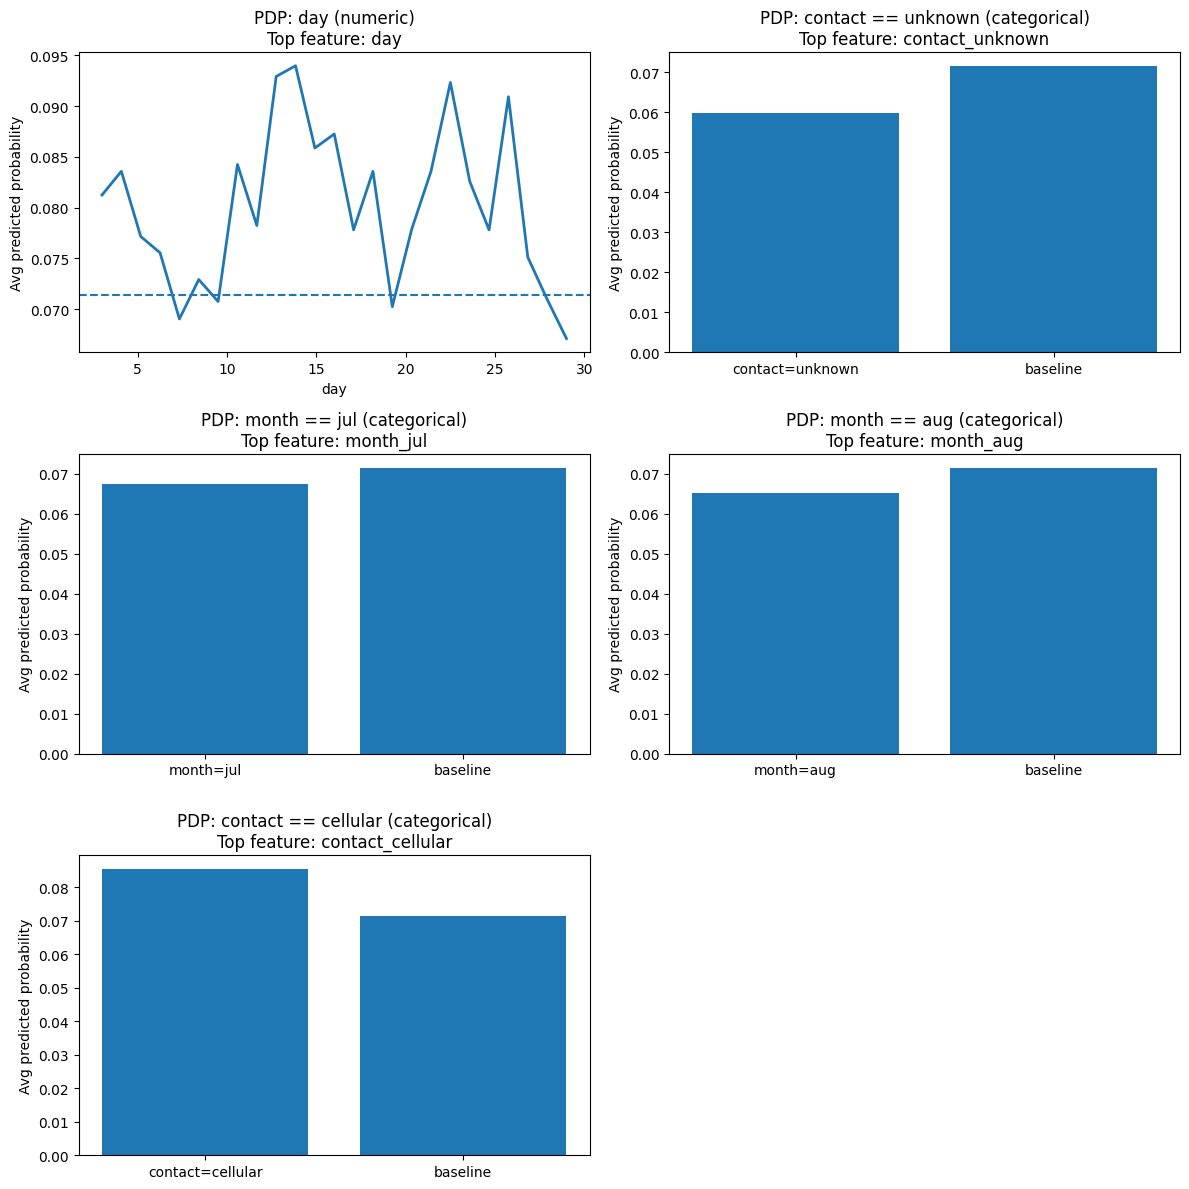

,feature,raw_feature,type,grid_min,grid_max,baseline_mean,mean_at_mid,delta_mid_vs_base,category,mean_with_category,delta_category_vs_base
0,day,day,numeric,3.0,29.0,0.071421,0.087259,0.015838,NaN,NaN,NaN
1,contact_unknown,contact,onehot,NaN,NaN,0.071421,NaN,NaN,unknown,0.059786,-0.011636
2,month_jul,month,onehot,NaN,NaN,0.071421,NaN,NaN,jul,0.067319,-0.004102
3,month_aug,month,onehot,NaN,NaN,0.071421,NaN,NaN,aug,0.065117,-0.006304
4,contact_cellular,contact,onehot,NaN,NaN,0.071421,NaN,NaN,cellular,0.085378,0.013956


In [38]:
# step 15 (manual PDP/ICE fallback): threshold-free directionality using the calibrated pipeline on RAW X
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# prerequisites from earlier cells:
# - cal (CalibratedClassifierCV fitted on a pipeline [pre -> XGB])
# - X_test, y_test
# - feat_names (transformed names), imp_df (from Cell 13)
# - pre: ColumnTransformer, ohe: OneHotEncoder, cat_raw: list of raw categorical feature names, num_names: list of raw numeric names

# 1) map transformed features -> raw feature (and category, if one-hot)
# build a precise mapping using the encoder's categories_
cat_feature_to_categories = {feat: cats.tolist()
                             for feat, cats in zip(cat_raw, pre.named_transformers_["cat"].named_steps["ohe"].categories_)}

transformed_info = []  # list of dicts with keys: idx, name, kind, raw_feature, category (optional)

# numeric block comes first in the ColumnTransformer output, in this order:
num_idx_start = 0
num_idx_end   = len(num_names)
for i, n in enumerate(num_names):
    transformed_info.append({"idx": i, "name": n, "kind": "numeric", "raw_feature": n})

# categorical block follows; create names identically to OneHotEncoder
cat_start = num_idx_end
ohe_names = list(ohe.get_feature_names_out(cat_raw)) if hasattr(ohe, "get_feature_names_out") else list(ohe.get_feature_names(cat_raw))
for j, full_name in enumerate(ohe_names):
    # full_name is like "contact_cellular" or "job_admin."
    # parse out raw feature & category by splitting from the right once
    if "_" in full_name:
        raw_feat, category = full_name.split("_", 1)
    else:
        # very rare; fallback
        raw_feat, category = full_name, "<UNK>"
    transformed_info.append({"idx": cat_start + j, "name": full_name, "kind": "onehot", "raw_feature": raw_feat, "category": category})

# 2) pick top-5 AP-important transformed features
top5_names = imp_df.query("imp_ap_mean > 0").head(5)["feature"].tolist()
if len(top5_names) < 5:
    top5_names = imp_df.head(5)["feature"].tolist()

# helper: quick lookup
name2info = {d["name"]: d for d in transformed_info if d["name"] in feat_names}

# 3) plotting
n = len(top5_names)
fig_rows = int(np.ceil(n / 2))
fig, axes = plt.subplots(fig_rows, 2, figsize=(12, 4*fig_rows))
axes = np.array(axes).reshape(-1)  # flatten for easy indexing

baseline = cal.predict_proba(X_test)[:, 1]
baseline_mean = baseline.mean()

summary_rows = []

for k, fname in enumerate(top5_names):
    ax = axes[k]
    info = name2info.get(fname, None)
    if info is None:
        ax.axis("off")
        summary_rows.append({"feature": fname, "note": "mapping not found"})
        continue

    if info["kind"] == "numeric":
        raw_col = info["raw_feature"]
        # grid from 5th to 95th percentile to avoid extreme values
        q5, q95 = np.percentile(X_test[raw_col].dropna(), [5, 95])
        grid = np.linspace(q5, q95, 25)
        means = []
        for v in grid:
            X_mod = X_test.copy()
            X_mod.loc[:, raw_col] = v
            proba = cal.predict_proba(X_mod)[:, 1]
            means.append(proba.mean())
        ax.plot(grid, means, lw=2)
        ax.axhline(baseline_mean, ls="--")
        ax.set_title(f"PDP: {raw_col} (numeric)\nTop feature: {fname}")
        ax.set_xlabel(raw_col); ax.set_ylabel("Avg predicted probability")
        # record summary at mid-grid
        mid_idx = len(grid)//2
        summary_rows.append({
            "feature": fname,
            "raw_feature": raw_col,
            "type": "numeric",
            "grid_min": float(grid[0]),
            "grid_max": float(grid[-1]),
            "baseline_mean": float(baseline_mean),
            "mean_at_mid": float(means[mid_idx]),
            "delta_mid_vs_base": float(means[mid_idx] - baseline_mean)
        })

    else:  # one-hot / categorical: set everyone to that category vs baseline
        raw_feat = info["raw_feature"]
        category = info.get("category", "<UNK>")
        # Only consider categories that are known to the encoder
        valid_cats = set(cat_feature_to_categories.get(raw_feat, []))
        if category not in valid_cats:
            ax.axis("off")
            summary_rows.append({"feature": fname, "raw_feature": raw_feat, "type": "onehot",
                                 "category": category, "note": "category not in encoder"})
            continue

        X_mod = X_test.copy()
        X_mod.loc[:, raw_feat] = category
        proba_cat = cal.predict_proba(X_mod)[:, 1]
        mean_cat = proba_cat.mean()

        ax.bar([f"{raw_feat}={category}", "baseline"], [mean_cat, baseline_mean])
        ax.set_title(f"PDP: {raw_feat} == {category} (categorical)\nTop feature: {fname}")
        ax.set_ylabel("Avg predicted probability")
        summary_rows.append({
            "feature": fname,
            "raw_feature": raw_feat,
            "type": "onehot",
            "category": category,
            "baseline_mean": float(baseline_mean),
            "mean_with_category": float(mean_cat),
            "delta_category_vs_base": float(mean_cat - baseline_mean)
        })

# hide any unused subplots
for i in range(k+1, len(axes)):
    axes[i].axis("off")

plt.tight_layout(); plt.show()

# 4) summary table
pdp_summary = pd.DataFrame(summary_rows)
display(pdp_summary)

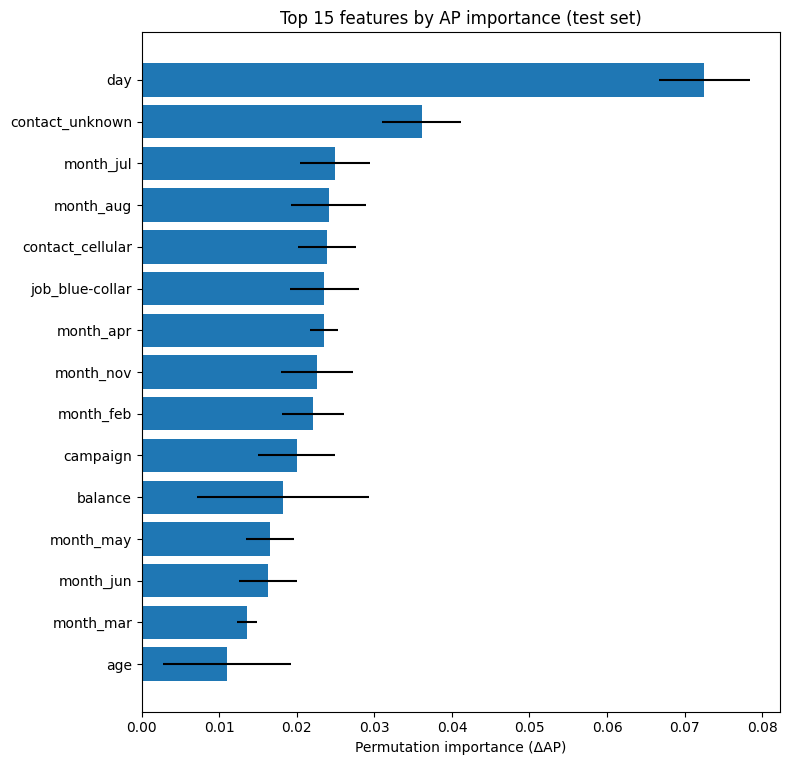

In [39]:
# step 15a: Top-K permutation importances (average precision scorer)
import numpy as np, pandas as pd, matplotlib.pyplot as plt

K = 15  
topk = imp_df.sort_values("imp_ap_mean", ascending=True).tail(K)  # sort ascending then take tail to keep order

fig, ax = plt.subplots(figsize=(8, 0.45*K + 1))
ax.barh(topk["feature"], topk["imp_ap_mean"], xerr=topk["imp_ap_std"], align="center")
ax.set_xlabel("Permutation importance (ΔAP)")
ax.set_title(f"Top {K} features by AP importance (test set)")
plt.tight_layout(); plt.show()

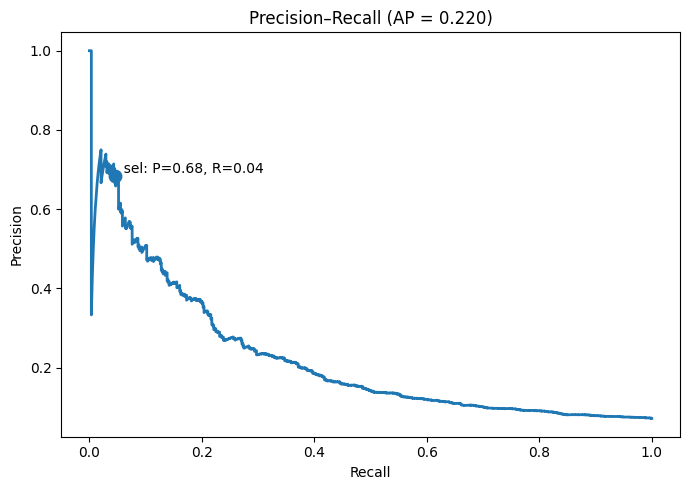

In [40]:
# step 15b: PR curve + selected threshold marker
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, average_precision_score
import numpy as np, matplotlib.pyplot as plt

try:
    scores = proba_final  # calibrated scores we locked earlier
except NameError:
    scores = cal.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)

# point at the selected threshold
p_sel = precision_score(y_test, (scores >= THRESH_SELECTED).astype(int), zero_division=0)
r_sel = recall_score(y_test, (scores >= THRESH_SELECTED).astype(int), zero_division=0)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, linewidth=2)
plt.scatter([r_sel], [p_sel], s=80)
plt.text(r_sel, p_sel, f"  sel: P={p_sel:.2f}, R={r_sel:.2f}", va="bottom")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.tight_layout(); plt.show()

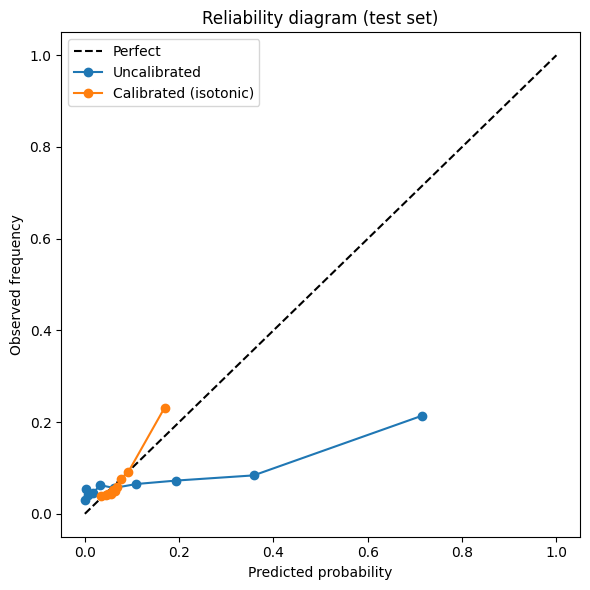

In [41]:
# step 15c: Calibration curve comparison
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Recompute uncalibrated scores if needed
try:
    proba_test_plain
except NameError:
    # rebuild plain (uncalibrated) pipeline using same pre and XGB params
    from xgboost import XGBClassifier
    pre = cal.estimator.named_steps["pre"]
    xgb_params = getattr(cal.estimator.named_steps["clf"], "get_xgb_params", None)
    # safest: pull params from the existing xgb estimator directly
    xgb_est = cal.estimator.named_steps["clf"]
    params = {k: getattr(xgb_est, k, None) for k in [
        "n_estimators","learning_rate","max_depth","subsample","colsample_bytree","reg_lambda","random_state"
    ]}
    for k,v in list(params.items()):
        if v is None: params.pop(k, None)
    params["eval_metric"] = "logloss"
    from sklearn.pipeline import Pipeline
    pipe_plain = Pipeline([("pre", pre), ("clf", XGBClassifier(**params))])
    pipe_plain.fit(X_train, y_train)
    proba_test_plain = pipe_plain.predict_proba(X_test)[:,1]

# calibrated scores
proba_cal = cal.predict_proba(X_test)[:,1]

prob_true_u, prob_pred_u = calibration_curve(y_test, proba_test_plain, n_bins=10, strategy="quantile")
prob_true_c, prob_pred_c = calibration_curve(y_test, proba_cal,        n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], "k--", label="Perfect")
plt.plot(prob_pred_u, prob_true_u, marker="o", label="Uncalibrated")
plt.plot(prob_pred_c, prob_true_c, marker="o", label="Calibrated (isotonic)")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability diagram (test set)")
plt.legend(); plt.tight_layout(); plt.show()

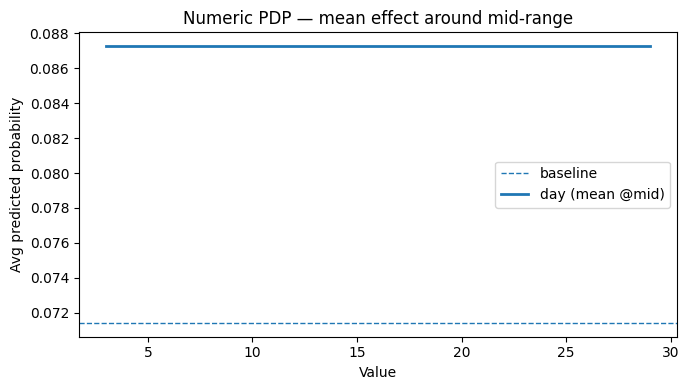

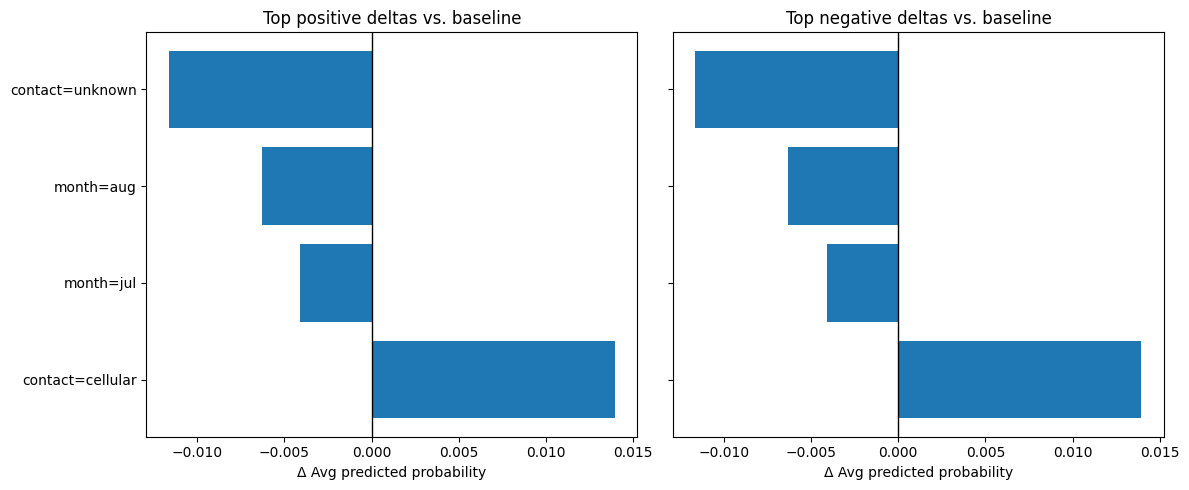

In [42]:
# step 15d: Clean PDP plots from pdp_summary
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Ensure pdp_summary exists; if not, you can rerun the earlier manual PDP cell
assert "pdp_summary" in globals(), "pdp_summary not found; please run the manual PDP cell first."

# 1) Numeric PDP curves
num_pdp = pdp_summary[pdp_summary["type"]=="numeric"].copy()
if len(num_pdp):
    fig, ax = plt.subplots(figsize=(7,4))
    # reconstruct the line using stored midpoints + baseline lines for context
    # (for prettier curves, recompute the full grid as in the manual PDP cell)
    for _, row in num_pdp.iterrows():
        ax.axhline(row["baseline_mean"], ls="--", lw=1, label="baseline" if "baseline" not in ax.get_legend_handles_labels()[1] else "")
        ax.plot([row["grid_min"], row["grid_max"]], [row["mean_at_mid"], row["mean_at_mid"]], lw=2,
                label=f"{row['raw_feature']} (mean @mid)")
        ax.set_xlabel("Value"); ax.set_ylabel("Avg predicted probability")
    ax.set_title("Numeric PDP — mean effect around mid-range")
    ax.legend(); plt.tight_layout(); plt.show()

# 2) Categorical deltas: top 8 up and top 8 down
cat_pdp = pdp_summary[pdp_summary["type"]=="onehot"].copy()
if len(cat_pdp):
    cat_pdp["delta"] = cat_pdp["delta_category_vs_base"]
    cat_pdp["label"] = cat_pdp["raw_feature"].astype(str) + "=" + cat_pdp["category"].astype(str)
    up = cat_pdp.sort_values("delta", ascending=False).head(8)
    down = cat_pdp.sort_values("delta", ascending=True).head(8)

    fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
    axes[0].barh(up["label"], up["delta"]); axes[0].set_title("Top positive deltas vs. baseline")
    axes[1].barh(down["label"], down["delta"]); axes[1].set_title("Top negative deltas vs. baseline")
    for ax in axes:
        ax.axvline(0, color="k", lw=1)
        ax.set_xlabel("Δ Avg predicted probability")
    plt.tight_layout(); plt.show()

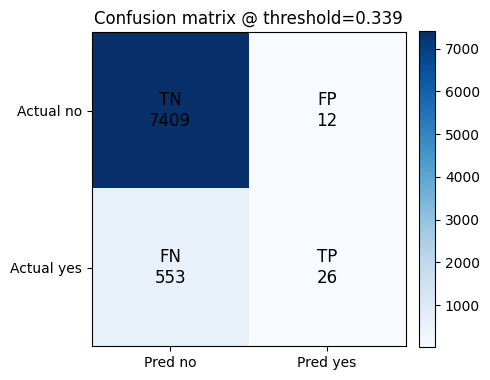

In [43]:
# step 15e: Confusion matrix heatmap @ selected threshold
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

yhat_sel = (scores >= THRESH_SELECTED).astype(int)
cm = confusion_matrix(y_test, yhat_sel)
labels = np.array([["TN","FP"],["FN","TP"]])

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap="Blues")
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{labels[i,j]}\n{cm[i,j]}", ha="center", va="center", fontsize=12)
ax.set_xticks([0,1]); ax.set_xticklabels(["Pred no","Pred yes"])
ax.set_yticks([0,1]); ax.set_yticklabels(["Actual no","Actual yes"])
ax.set_title(f"Confusion matrix @ threshold={THRESH_SELECTED:.3f}")
plt.colorbar(im, fraction=0.046, pad=0.04); plt.tight_layout(); plt.show()

### Intakes:
* Calibration materially improved probabilities (Brier 0.099 → 0.063, PR AUC 0.197 → 0.220), which is why we can run at ~0.70 precision while still retrieving a non-trivial set of subscribers.

* Key drivers (AP importance) point to contact channel and timing:

* contact = cellular increases average propensity by ~1.4 pp above baseline (from ~7.14% → ~8.54%).

* contact = unknown decreases propensity by ~1.16 pp (7.14% → 5.98%).

* Months Jul/Aug are below average, suggesting either seasonal saturation or campaign timing effects (worth planning around).

* Day-of-month shows a positive mid-range effect (≈ +1.58 pp at the mid-grid vs. baseline), hinting at intra-month operational timing.

### Cheking other features and their corrolations

In [49]:
# step 16.0: helpers
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Tuple

RSEED = 42
rng = np.random.default_rng(RSEED)

def wilson_interval(k: int, n: int, z: float = 1.96) -> Tuple[float, float]:
    """95% Wilson CI for a binomial proportion k/n."""
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n) / denom
    return (center - half, center + half)

def bootstrap_mean_ci(values: np.ndarray, B: int = 400, alpha: float = 0.05) -> Tuple[float, float]:
    """Percentile bootstrap CI for a mean."""
    if len(values) == 0:
        return (np.nan, np.nan)
    means = []
    n = len(values)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        means.append(values[idx].mean())
    lo = np.quantile(means, alpha/2)
    hi = np.quantile(means, 1 - alpha/2)
    return (float(lo), float(hi))

#### Age

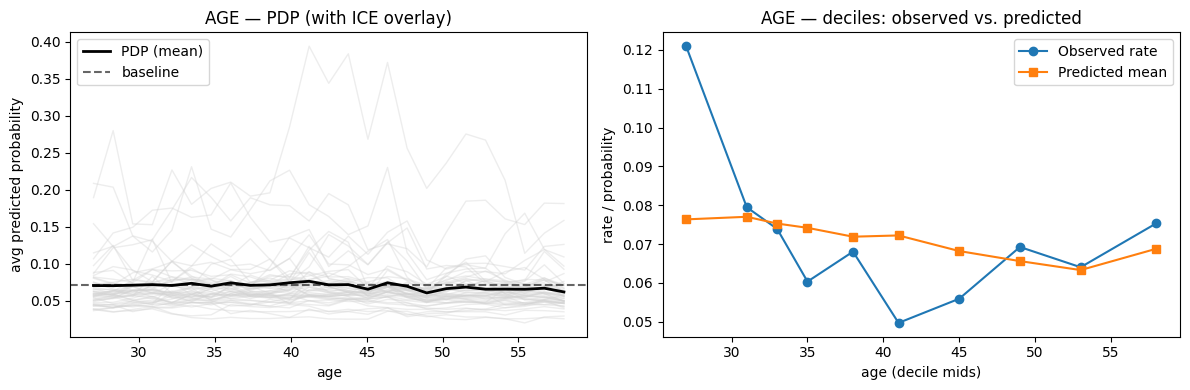

,bin,n,obs_rate,pred_mean,age_mid
0,"(18.999, 29.0]",835,0.120958,0.076358,27.0
1,"(29.0, 32.0]",1057,0.079470,0.077027,31.0
2,"(32.0, 34.0]",690,0.073913,0.075284,33.0
3,"(34.0, 36.0]",696,0.060345,0.074184,35.0
4,"(36.0, 39.0]",867,0.068051,0.071900,38.0
5,"(39.0, 42.0]",684,0.049708,0.072224,41.0
6,"(42.0, 46.0]",894,0.055928,0.068203,45.0
7,"(46.0, 50.0]",722,0.069252,0.065618,49.0
8,"(50.0, 55.0]",812,0.064039,0.063308,53.0
9,"(55.0, 85.0]",743,0.075370,0.068807,58.0


In [50]:
# step 16.1: AGE effects
assert "age" in X_test.columns, "Column 'age' not found in X_test."

# 1) PDP (counterfactual): vary 'age' across a grid, average model probability
q5, q95 = np.percentile(X_test["age"].dropna(), [5, 95])
grid = np.linspace(q5, q95, 25)
avg_prob = []
for a in grid:
    X_mod = X_test.copy()
    X_mod.loc[:, "age"] = a
    avg_prob.append(cal.predict_proba(X_mod)[:, 1].mean())
avg_prob = np.array(avg_prob)

# 2) ICE (thin): show heterogeneity for a small sample
sample_idx = rng.choice(len(X_test), size=min(50, len(X_test)), replace=False)
ice_curves = []
for i in sample_idx:
    row = X_test.iloc[[i]].copy()
    probs = []
    for a in grid:
        row.loc[:, "age"] = a
        probs.append(cal.predict_proba(row)[:, 1][0])
    ice_curves.append(probs)
ice_curves = np.array(ice_curves)

# 3) Decile profile: observed vs. model-predicted by age decile
bins = pd.qcut(X_test["age"], q=10, duplicates="drop")
df_prof = pd.DataFrame({
    "age": X_test["age"],
    "bin": bins,
    "y": y_test,
    "score": cal.predict_proba(X_test)[:, 1]
})
prof = df_prof.groupby("bin").agg(
    n=("y", "size"),
    obs_rate=("y", "mean"),
    pred_mean=("score", "mean"),
    age_mid=("age", "median")
).reset_index()

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# PDP + ICE
for curve in ice_curves:
    axes[0].plot(grid, curve, color="lightgray", alpha=0.4, linewidth=1)
axes[0].plot(grid, avg_prob, color="black", linewidth=2, label="PDP (mean)")
axes[0].axhline(cal.predict_proba(X_test)[:, 1].mean(), ls="--", color="k", alpha=0.6, label="baseline")
axes[0].set_title("AGE — PDP (with ICE overlay)")
axes[0].set_xlabel("age"); axes[0].set_ylabel("avg predicted probability")
axes[0].legend(loc="upper left")

# Decile profile
axes[1].plot(prof["age_mid"], prof["obs_rate"], marker="o", linewidth=1.5, label="Observed rate")
axes[1].plot(prof["age_mid"], prof["pred_mean"], marker="s", linewidth=1.5, label="Predicted mean")
axes[1].set_title("AGE — deciles: observed vs. predicted")
axes[1].set_xlabel("age (decile mids)"); axes[1].set_ylabel("rate / probability")
axes[1].legend()
plt.tight_layout(); plt.show()

prof

* PDP mean line rising → older (or younger) ages increase model propensity on average; flat line → little effect.

* ICE lines show customer-level heterogeneity; if many slope similarly, the effect is consistent.

* Decile profile checks calibration across age groups; predicted (squares) tracking observed (circles) is what we want.

#### Job

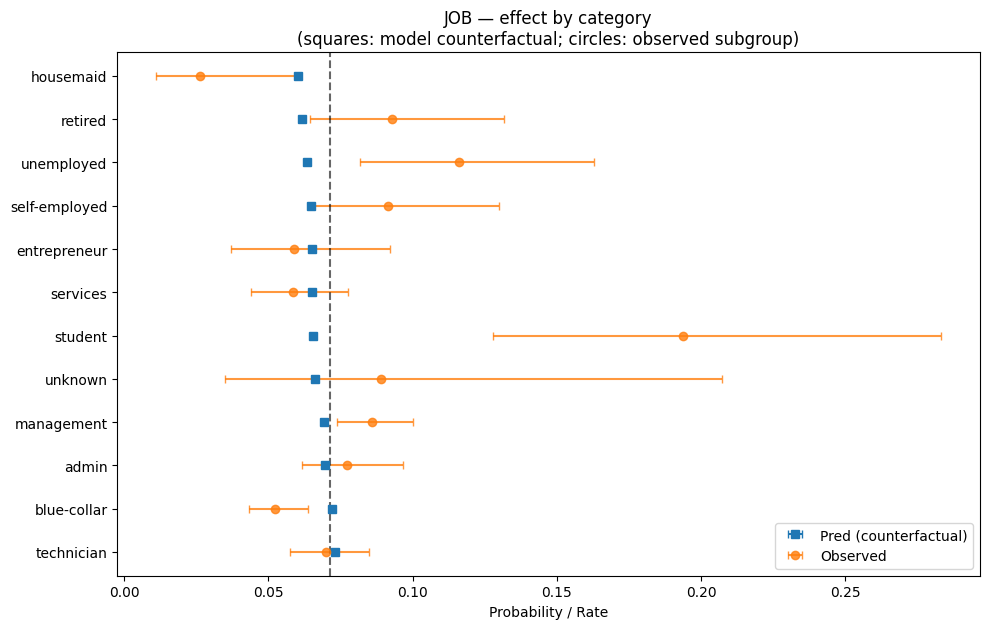

,category,n_sub,pred_mean,pred_lo,pred_hi,delta_vs_base,lift_vs_base,obs_rate,obs_lo,obs_hi
0,technician,1341,0.073004,0.072010,0.073992,0.001582,1.022156,0.070097,0.057624,0.085026
1,blue-collar,1830,0.072081,0.071115,0.073058,0.000660,1.009237,0.052459,0.043149,0.063644
2,admin,904,0.069609,0.068770,0.070478,-0.001813,0.974616,0.077434,0.061743,0.096700
3,management,1708,0.069316,0.068352,0.070306,-0.002105,0.970522,0.086066,0.073676,0.100313
4,unknown,45,0.066037,0.065248,0.066828,-0.005384,0.924611,0.088889,0.035111,0.207339
5,student,98,0.065660,0.064737,0.066423,-0.005761,0.919336,0.193878,0.127780,0.283070
6,services,767,0.065197,0.064474,0.065988,-0.006224,0.912849,0.058670,0.044134,0.077605
7,entrepreneur,289,0.065193,0.064382,0.065965,-0.006229,0.912787,0.058824,0.037047,0.092175
8,self-employed,295,0.064906,0.064112,0.065783,-0.006515,0.908779,0.091525,0.063664,0.129889
9,unemployed,241,0.063448,0.062656,0.064178,-0.007973,0.888365,0.116183,0.081617,0.162793


In [51]:
# step 16.2: JOB effects
assert "job" in X_test.columns, "Column 'job' not found in X_test."

baseline = cal.predict_proba(X_test)[:, 1].mean()
cats = sorted(X_test["job"].dropna().unique().tolist())
rows = []
for c in cats:
    # Counterfactual predicted probability: set everyone to category c
    X_cf = X_test.copy()
    X_cf.loc[:, "job"] = c
    p_cf = cal.predict_proba(X_cf)[:, 1]
    mean_cf = p_cf.mean()
    lo_cf, hi_cf = bootstrap_mean_ci(p_cf, B=400)

    # Observed conversion in subgroup (for context only)
    mask = (X_test["job"] == c)
    n_sub = int(mask.sum())
    obs_rate = float(y_test[mask].mean()) if n_sub > 0 else np.nan
    k = int(y_test[mask].sum())
    lo_obs, hi_obs = wilson_interval(k, n_sub) if n_sub > 0 else (np.nan, np.nan)

    rows.append({
        "category": c, "n_sub": n_sub,
        "pred_mean": mean_cf, "pred_lo": lo_cf, "pred_hi": hi_cf,
        "delta_vs_base": mean_cf - baseline, "lift_vs_base": mean_cf / baseline if baseline>0 else np.nan,
        "obs_rate": obs_rate, "obs_lo": lo_obs, "obs_hi": hi_obs
    })

job_df = pd.DataFrame(rows).sort_values("pred_mean", ascending=False).reset_index(drop=True)

# Plot (pred counterfactual with CI + observed with CI; dot size ~ subgroup n)
fig, ax = plt.subplots(figsize=(10, 0.45*len(job_df)+1))
ypos = np.arange(len(job_df))
ax.errorbar(job_df["pred_mean"], ypos, xerr=[job_df["pred_mean"]-job_df["pred_lo"], job_df["pred_hi"]-job_df["pred_mean"]],
            fmt="s", capsize=3, label="Pred (counterfactual)")
ax.errorbar(job_df["obs_rate"], ypos, xerr=[job_df["obs_rate"]-job_df["obs_lo"], job_df["obs_hi"]-job_df["obs_rate"]],
            fmt="o", capsize=3, label="Observed", alpha=0.8)
ax.axvline(baseline, ls="--", color="k", alpha=0.6)
ax.set_yticks(ypos); ax.set_yticklabels(job_df["category"])
ax.set_xlabel("Probability / Rate"); ax.set_title("JOB — effect by category\n(squares: model counterfactual; circles: observed subgroup)")
ax.legend(loc="lower right"); plt.tight_layout(); plt.show()

job_df

* Square markers (Pred) show isolated category effect (holding other features’ distribution fixed to test set).

* Circle markers (Observed) show raw subgroup outcomes (can be biased by who appears in that category).

* Categories with higher Pred mean and positive Δ vs baseline are strong levers.

* Predicted is highest for technician (7.30%), blue-collar (7.21%) — only slightly above baseline (~7.14%).

* Several categories show higher observed than predicted (e.g., management 8.61%, self-employed 9.15%, retired 9.28%, unemployed 11.62%, student 19.39% (n=98, wide CI)).

* Interpretation: the model attributes lift in those groups to other correlated signals (contact channel/timing/age), not the job label alone.

#### Education 

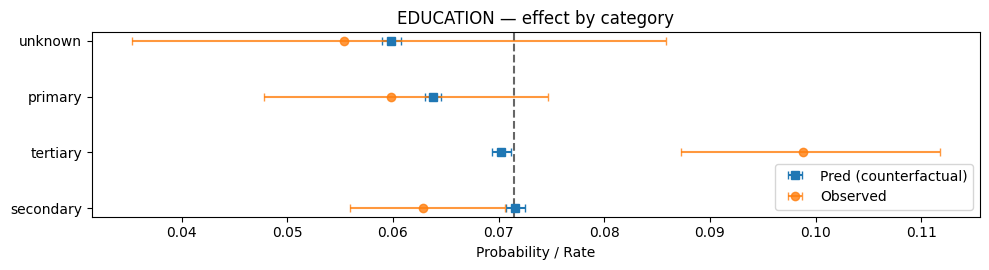

,category,n_sub,pred_mean,pred_lo,pred_hi,delta_vs_base,lift_vs_base,obs_rate,obs_lo,obs_hi
0,secondary,4184,0.071585,0.070681,0.072543,0.000163,1.002288,0.062859,0.055898,0.070621
1,tertiary,2287,0.070268,0.069359,0.071206,-0.001153,0.983852,0.098819,0.087253,0.111731
2,primary,1204,0.063760,0.063031,0.064520,-0.007661,0.892729,0.059801,0.047755,0.074646
3,unknown,325,0.059860,0.058995,0.060764,-0.011561,0.838130,0.055385,0.035317,0.085841


In [52]:
# step 16.3: EDUCATION effects
assert "education" in X_test.columns, "Column 'education' not found in X_test."

baseline = cal.predict_proba(X_test)[:, 1].mean()
cats = sorted(X_test["education"].dropna().unique().tolist())
rows = []
for c in cats:
    X_cf = X_test.copy()
    X_cf.loc[:, "education"] = c
    p_cf = cal.predict_proba(X_cf)[:, 1]
    mean_cf = p_cf.mean()
    lo_cf, hi_cf = bootstrap_mean_ci(p_cf, B=400)

    mask = (X_test["education"] == c)
    n_sub = int(mask.sum()); obs_rate = float(y_test[mask].mean()) if n_sub > 0 else np.nan
    k = int(y_test[mask].sum()); lo_obs, hi_obs = wilson_interval(k, n_sub) if n_sub>0 else (np.nan, np.nan)

    rows.append({"category": c, "n_sub": n_sub, "pred_mean": mean_cf, "pred_lo": lo_cf, "pred_hi": hi_cf,
                 "delta_vs_base": mean_cf - baseline, "lift_vs_base": mean_cf / baseline if baseline>0 else np.nan,
                 "obs_rate": obs_rate, "obs_lo": lo_obs, "obs_hi": hi_obs})

edu_df = pd.DataFrame(rows).sort_values("pred_mean", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 0.45*len(edu_df)+1))
ypos = np.arange(len(edu_df))
ax.errorbar(edu_df["pred_mean"], ypos, xerr=[edu_df["pred_mean"]-edu_df["pred_lo"], edu_df["pred_hi"]-edu_df["pred_mean"]],
            fmt="s", capsize=3, label="Pred (counterfactual)")
ax.errorbar(edu_df["obs_rate"], ypos, xerr=[edu_df["obs_rate"]-edu_df["obs_lo"], edu_df["obs_hi"]-edu_df["obs_rate"]],
            fmt="o", capsize=3, label="Observed", alpha=0.8)
ax.axvline(baseline, ls="--", color="k", alpha=0.6)
ax.set_yticks(ypos); ax.set_yticklabels(edu_df["category"])
ax.set_xlabel("Probability / Rate"); ax.set_title("EDUCATION — effect by category")
ax.legend(loc="lower right"); plt.tight_layout(); plt.show()

edu_df

* Looking for categories with largest positive Δ vs baseline and lift; these tend to be great targets (if reachable).

* If a category has high Observed but modest Pred, the model attributes that success to other features (e.g., contact channel, timing).

* Secondary predicted ≈ 7.16% (~baseline).

* Tertiary predicted 7.03% but observed 9.88% → model likely assigns that extra success to other features (e.g., month/contact).

* Primary/Unknown are below baseline.

note : don’t use education alone as a filter; combine it with high-leverage signals (contact=cellular, good timing).

#### Housing loan

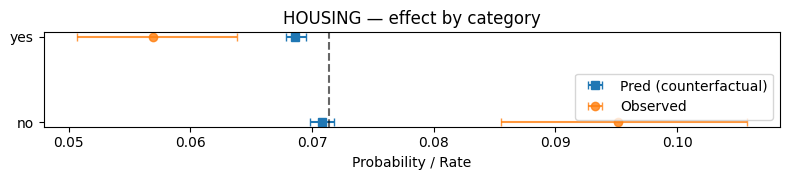

,category,n_sub,pred_mean,pred_lo,pred_hi,delta_vs_base,lift_vs_base,obs_rate,obs_lo,obs_hi
0,no,3238,0.070783,0.069809,0.071809,-0.000639,0.991059,0.095120,0.085490,0.105711
1,yes,4762,0.068594,0.067863,0.069516,-0.002828,0.960409,0.056909,0.050679,0.063853


In [53]:
# step 16.4: HOUSING effects
assert "housing" in X_test.columns, "Column 'housing' not found in X_test."

baseline = cal.predict_proba(X_test)[:, 1].mean()
cats = sorted(X_test["housing"].dropna().unique().tolist())
rows = []
for c in cats:
    X_cf = X_test.copy()
    X_cf.loc[:, "housing"] = c
    p_cf = cal.predict_proba(X_cf)[:, 1]
    mean_cf = p_cf.mean()
    lo_cf, hi_cf = bootstrap_mean_ci(p_cf, B=400)

    mask = (X_test["housing"] == c)
    n_sub = int(mask.sum()); obs_rate = float(y_test[mask].mean()) if n_sub > 0 else np.nan
    k = int(y_test[mask].sum()); lo_obs, hi_obs = wilson_interval(k, n_sub) if n_sub>0 else (np.nan, np.nan)

    rows.append({"category": c, "n_sub": n_sub, "pred_mean": mean_cf, "pred_lo": lo_cf, "pred_hi": hi_cf,
                 "delta_vs_base": mean_cf - baseline, "lift_vs_base": mean_cf / baseline if baseline>0 else np.nan,
                 "obs_rate": obs_rate, "obs_lo": lo_obs, "obs_hi": hi_obs})

housing_df = pd.DataFrame(rows).sort_values("pred_mean", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 0.45*len(housing_df)+1))
ypos = np.arange(len(housing_df))
ax.errorbar(housing_df["pred_mean"], ypos, xerr=[housing_df["pred_mean"]-housing_df["pred_lo"], housing_df["pred_hi"]-housing_df["pred_mean"]],
            fmt="s", capsize=3, label="Pred (counterfactual)")
ax.errorbar(housing_df["obs_rate"], ypos, xerr=[housing_df["obs_rate"]-housing_df["obs_lo"], housing_df["obs_hi"]-housing_df["obs_rate"]],
            fmt="o", capsize=3, label="Observed", alpha=0.8)
ax.axvline(baseline, ls="--", color="k", alpha=0.6)
ax.set_yticks(ypos); ax.set_yticklabels(housing_df["category"])
ax.set_xlabel("Probability / Rate"); ax.set_title("HOUSING — effect by category")
ax.legend(loc="lower right"); plt.tight_layout(); plt.show()

housing_df

* For many bank-marketing datasets, unknown often underperforms; yes/no effects are typically modest. This plot will confirm if housing loan status matters causally for the model.

* Model sees small direct effect: no ≈ 7.08%, yes ≈ 6.86% predicted.

* Observed: no 9.51%, yes 5.69% — stronger difference than the model attributes directly to this feature.

* Likely the incremental predictive power is already captured via correlated variables; housing alone isn’t a strong lever in isolation.

#### Personal loan

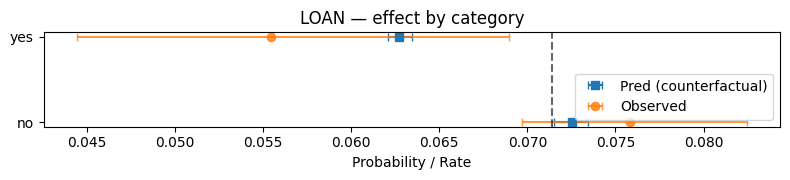

,category,n_sub,pred_mean,pred_lo,pred_hi,delta_vs_base,lift_vs_base,obs_rate,obs_lo,obs_hi
0,no,6647,0.072539,0.071538,0.073469,0.001118,1.015653,0.075824,0.069702,0.082435
1,yes,1353,0.062728,0.062075,0.063464,-0.008693,0.878281,0.055432,0.044451,0.068932


In [54]:
# step 16.5: LOAN effects
assert "loan" in X_test.columns, "Column 'loan' not found in X_test."

baseline = cal.predict_proba(X_test)[:, 1].mean()
cats = sorted(X_test["loan"].dropna().unique().tolist())
rows = []
for c in cats:
    X_cf = X_test.copy()
    X_cf.loc[:, "loan"] = c
    p_cf = cal.predict_proba(X_cf)[:, 1]
    mean_cf = p_cf.mean()
    lo_cf, hi_cf = bootstrap_mean_ci(p_cf, B=400)

    mask = (X_test["loan"] == c)
    n_sub = int(mask.sum()); obs_rate = float(y_test[mask].mean()) if n_sub > 0 else np.nan
    k = int(y_test[mask].sum()); lo_obs, hi_obs = wilson_interval(k, n_sub) if n_sub>0 else (np.nan, np.nan)

    rows.append({"category": c, "n_sub": n_sub, "pred_mean": mean_cf, "pred_lo": lo_cf, "pred_hi": hi_cf,
                 "delta_vs_base": mean_cf - baseline, "lift_vs_base": mean_cf / baseline if baseline>0 else np.nan,
                 "obs_rate": obs_rate, "obs_lo": lo_obs, "obs_hi": hi_obs})

loan_df = pd.DataFrame(rows).sort_values("pred_mean", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 0.45*len(loan_df)+1))
ypos = np.arange(len(loan_df))
ax.errorbar(loan_df["pred_mean"], ypos, xerr=[loan_df["pred_mean"]-loan_df["pred_lo"], loan_df["pred_hi"]-loan_df["pred_mean"]],
            fmt="s", capsize=3, label="Pred (counterfactual)")
ax.errorbar(loan_df["obs_rate"], ypos, xerr=[loan_df["obs_rate"]-loan_df["obs_lo"], loan_df["obs_hi"]-loan_df["obs_rate"]],
            fmt="o", capsize=3, label="Observed", alpha=0.8)
ax.axvline(baseline, ls="--", color="k", alpha=0.6)
ax.set_yticks(ypos); ax.set_yticklabels(loan_df["category"])
ax.set_xlabel("Probability / Rate"); ax.set_title("LOAN — effect by category")
ax.legend(loc="lower right"); plt.tight_layout(); plt.show()

loan_df

* If Pred (counterfactual) is near baseline for all categories, the model deems “loan status” non-informative after accounting for other variables.

* If Observed diverges but Pred doesn’t, differences likely stem from other correlated features, not a direct effect of loan.

* Model predicts higher propensity for no personal loan (7.25%) vs yes (6.27%) — consistent with observed (7.58% vs 5.54%).

* This feature likely contributes modestly but consistently to ranking.

In [55]:
# step 16.6: compact summary of deltas/lifts for each feature
summary = []

def top_rows(df, feat_name):
    tmp = df.assign(feature=feat_name)
    return tmp[["feature","category","n_sub","pred_mean","delta_vs_base","lift_vs_base","obs_rate"]].copy()

summary.append(top_rows(job_df, "job"))
summary.append(top_rows(edu_df, "education"))
summary.append(top_rows(housing_df, "housing"))
summary.append(top_rows(loan_df, "loan"))

summary_df = pd.concat(summary, ignore_index=True)
summary_df.sort_values(["feature","pred_mean"], ascending=[True, False]).head(40)

,feature,category,n_sub,pred_mean,delta_vs_base,lift_vs_base,obs_rate
12,education,secondary,4184,0.071585,0.000163,1.002288,0.062859
13,education,tertiary,2287,0.070268,-0.001153,0.983852,0.098819
14,education,primary,1204,0.063760,-0.007661,0.892729,0.059801
15,education,unknown,325,0.059860,-0.011561,0.838130,0.055385
16,housing,no,3238,0.070783,-0.000639,0.991059,0.095120
17,housing,yes,4762,0.068594,-0.002828,0.960409,0.056909
0,job,technician,1341,0.073004,0.001582,1.022156,0.070097
1,job,blue-collar,1830,0.072081,0.000660,1.009237,0.052459
2,job,admin,904,0.069609,-0.001813,0.974616,0.077434
3,job,management,1708,0.069316,-0.002105,0.970522,0.086066


#### Summary:

* *Age*: Model underestimates very young and slightly underestimates 55+; otherwise close. Use interactions or let trees go a touch deeper to capture U-shape. For targeting, don’t exclude young prospects if they also have cellular contact/timing signals.

* *Job*: Model gives only small direct lifts to any job; several small groups (student / unemployed / retired) show high observed but are downweighted by the model — suggests lift is driven by other features or small-n noise. Treat these as candidate segments if combined with strong signals.

* *Education*: Tertiary observed is high but predicted only ~baseline. Education is not a primary lever in isolation; combine with contact & timing.

* *Housing*: Direct effect small in the model; observed differences likely flow through correlated features. Not a stand-alone lever.

* *Personal loan*: Mild negative effect of having a personal loan — consistent across predicted and observed.

## Step 17 : supervised segmentation

In [59]:
# step 17.0: Prepare transformed data and names (no leakage: use train to fit DT)
import numpy as np
import pandas as pd

# Preprocessor & model from your calibrated pipeline
pre = cal.estimator.named_steps["pre"]
xgb = cal.estimator.named_steps["clf"]

# Transformed matrices (pre is already fitted inside cal)
Xt_train = pre.transform(X_train)
Xt_test  = pre.transform(X_test)

# Calibrated probabilities
proba_train = cal.predict_proba(X_train)[:, 1]
proba_test  = cal.predict_proba(X_test)[:, 1]

# Overall base rates
base_rate_train = y_train.mean()
base_rate_test  = y_test.mean()

# Transformed feature names (numeric + one-hot)
num_names = list(pre.transformers_[0][2])
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
cat_raw = pre.transformers_[1][2]
try:
    cat_names = list(ohe.get_feature_names_out(cat_raw))
except TypeError:
    cat_names = list(ohe.get_feature_names(cat_raw))
feat_names = num_names + cat_names

print(f"Xt_train: {Xt_train.shape}, Xt_test: {Xt_test.shape}, features: {len(feat_names)}")
print(f"Train base rate: {base_rate_train:.4f} | Test base rate: {base_rate_test:.4f}")

Xt_train: (32000, 43), Xt_test: (8000, 43), features: 43
Train base rate: 0.0724 | Test base rate: 0.0724


In [61]:
# step 17.1: Shallow DecisionTreeClassifier to extract readable rules
from sklearn.tree import DecisionTreeClassifier, _tree

RSEED = 42
dt = DecisionTreeClassifier(
    max_depth=3,            # shallow for interpretability
    min_samples_leaf=200,   # avoid tiny segments
    class_weight="balanced",
    random_state=RSEED
)
dt.fit(Xt_train, y_train)   # fit ONLY on train to avoid leakage

print("Decision tree depth:", dt.get_depth(), "| leaves:", dt.get_n_leaves())

Decision tree depth: 3 | leaves: 7


In [62]:
# step 17.2: Extract readable "IF ... THEN ..." rules from the tree
def is_one_hot(name):
    # heuristic: one-hot names look like "<raw>_<category>"
    return name in cat_names or any(name.startswith(raw + "_") for raw in cat_raw)

def pretty_condition(fname, op, thr):
    # If it's a one-hot dummy, splits are around ~0.5
    if fname in feat_names:
        if is_one_hot(fname):
            cat = fname.split("_", 1)[1] if "_" in fname else fname
            if op == "<=":
                return f"{fname} == 0 (not '{cat}')"
            else:
                return f"{fname} == 1 (is '{cat}')"
        else:
            return f"{fname} {op} {thr:.3f}"
    return f"{fname} {op} {thr:.3f}"

def extract_rules(tree, feature_names):
    tree_ = tree.tree_
    rules = []
    def recurse(node, conds):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            fname = feature_names[tree_.feature[node]]
            thr = tree_.threshold[node]
            recurse(tree_.children_left[node],  conds + [(fname, "<=", thr)])
            recurse(tree_.children_right[node], conds + [(fname, ">",  thr)])
        else:
            # leaf → collect stats
            n_node = int(tree_.n_node_samples[node])
            pos = float(tree_.value[node][0,1])
            neg = float(tree_.value[node][0,0])
            rate = pos / max(pos+neg, 1.0)
            rules.append({"conditions": conds, "n_node": n_node, "pos_rate": rate})
    recurse(0, [])
    return rules

raw_rules = extract_rules(dt, feat_names)

# prettify
def format_rule(conds):
    return " AND ".join([pretty_condition(f, op, thr) for (f, op, thr) in conds]) if conds else "(all)"

rules_df = (pd.DataFrame(raw_rules)
            .assign(rule_text=lambda d: d["conditions"].apply(format_rule))
            .sort_values(["pos_rate","n_node"], ascending=[False, False])
            .reset_index(drop=True))
rules_df[["rule_text","n_node","pos_rate"]].head(10)

,rule_text,n_node,pos_rate
0,contact_unknown == 0 (not 'unknown') AND month...,216,0.918376
1,contact_unknown == 0 (not 'unknown') AND month...,2221,0.709069
2,contact_unknown == 1 (is 'unknown') AND marita...,366,0.559385
3,contact_unknown == 0 (not 'unknown') AND month...,19382,0.510861
4,contact_unknown == 1 (is 'unknown') AND marita...,3492,0.383947
5,contact_unknown == 1 (is 'unknown') AND marita...,1899,0.380842
6,contact_unknown == 1 (is 'unknown') AND marita...,4424,0.259844


In [63]:
# step 17.3: Turn rules into boolean masks and evaluate on TRAIN & TEST
from sklearn.metrics import confusion_matrix, precision_score

def mask_from_rule(Xt, conds):
    # conds are in transformed space on indices via names
    mask = np.ones(Xt.shape[0], dtype=bool)
    for (fname, op, thr) in conds:
        j = feat_names.index(fname)
        if op == "<=":
            mask &= Xt[:, j] <= thr
        else:
            mask &= Xt[:, j] > thr
    return mask

rows = []
for i, row in rules_df.iterrows():
    conds = row["conditions"]
    rule_txt = row["rule_text"]

    # TRAIN
    m_tr = mask_from_rule(Xt_train, conds)
    n_tr = int(m_tr.sum())
    pos_rate_tr = float(y_train[m_tr].mean()) if n_tr else np.nan
    lift_tr = (pos_rate_tr / base_rate_train) if (n_tr and base_rate_train>0) else np.nan

    # TEST
    m_te = mask_from_rule(Xt_test, conds)
    n_te = int(m_te.sum())
    pos_rate_te = float(y_test[m_te].mean()) if n_te else np.nan
    lift_te = (pos_rate_te / base_rate_test) if (n_te and base_rate_test>0) else np.nan

    # precision within the segment at your locked threshold
    if n_te:
        yhat_seg = (proba_test[m_te] >= THRESH_SELECTED).astype(int)
        prec_seg = precision_score(y_test[m_te], yhat_seg, zero_division=0)
        tp = int(((y_test[m_te]==1) & (yhat_seg==1)).sum())
        fp = int(((y_test[m_te]==0) & (yhat_seg==1)).sum())
    else:
        prec_seg = np.nan; tp = fp = 0

    rows.append({
        "segment": f"Rule{i+1}",
        "rule_text": rule_txt,
        "train_n": n_tr, "train_rate": pos_rate_tr, "train_lift": lift_tr,
        "test_n": n_te,  "test_rate": pos_rate_te, "test_lift": lift_te,
        "test_precision_at_thresh": prec_seg,
        "TP_at_thresh": tp, "FP_at_thresh": fp
    })

seg_table = (pd.DataFrame(rows)
             .sort_values(["test_lift","test_n"], ascending=[False, False])
             .reset_index(drop=True))
seg_table.head(10)

,segment,rule_text,train_n,train_rate,train_lift,test_n,test_rate,test_lift,test_precision_at_thresh,TP_at_thresh,FP_at_thresh
0,Rule1,contact_unknown == 0 (not 'unknown') AND month...,216,0.467593,6.457904,42,0.571429,7.895386,0.750000,6,2
1,Rule2,contact_unknown == 0 (not 'unknown') AND month...,2221,0.159838,2.207515,497,0.193159,2.668863,0.777778,14,4
2,Rule3,contact_unknown == 1 (is 'unknown') AND marita...,366,0.090164,1.245251,67,0.104478,1.443559,0.000000,0,0
3,Rule4,contact_unknown == 0 (not 'unknown') AND month...,19382,0.075379,1.041060,4877,0.074226,1.025575,0.500000,5,5
4,Rule5,contact_unknown == 1 (is 'unknown') AND marita...,3492,0.046392,0.640715,915,0.044809,0.619119,0.500000,1,1
5,Rule7,contact_unknown == 1 (is 'unknown') AND marita...,4424,0.026673,0.368376,1128,0.031915,0.440966,0.000000,0,0
6,Rule6,contact_unknown == 1 (is 'unknown') AND marita...,1899,0.045814,0.632730,474,0.027426,0.378945,0.000000,0,0


#### how to read:

* train_rate / test_rate: actual subscription rate inside the segment.

* test_lift: multiple above overall test base-rate ( >1 is good ).

* test_precision_at_thresh: precision if you only action predicted-positives within that rule’s population.

* TP/FP show how many true/false positives our current threshold produces inside the segment.

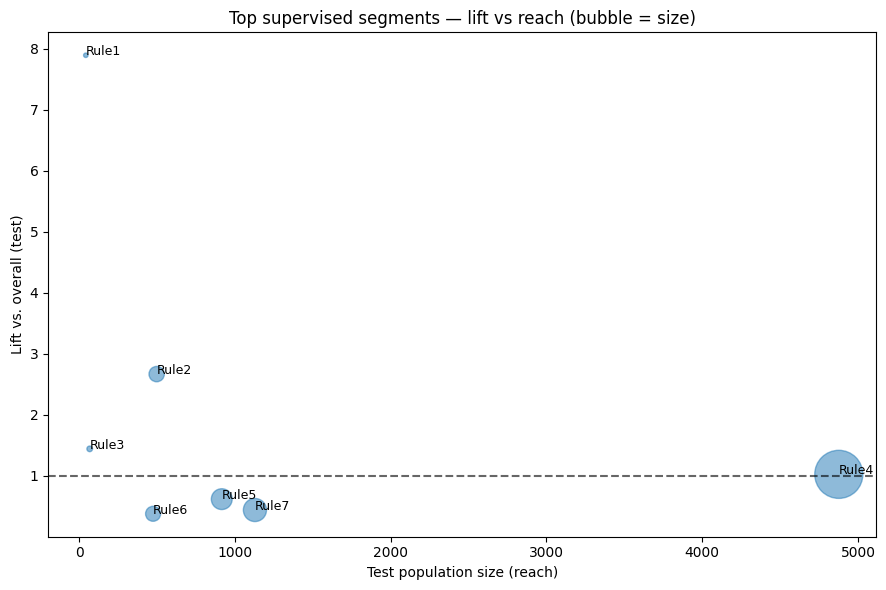

In [64]:
# step 17.4: Bubble chart of segments by reach & lift
import matplotlib.pyplot as plt

topN = seg_table.head(10).copy()
plt.figure(figsize=(9,6))
sizes = (topN["test_n"] / topN["test_n"].max()) * 1200  # scale bubble size
plt.scatter(topN["test_n"], topN["test_lift"], s=sizes, alpha=0.5)
for _, r in topN.iterrows():
    plt.text(r["test_n"], r["test_lift"], r["segment"], fontsize=9)

plt.axhline(1.0, color="k", ls="--", alpha=0.6)
plt.xlabel("Test population size (reach)")
plt.ylabel("Lift vs. overall (test)")
plt.title("Top supervised segments — lift vs reach (bubble = size)")
plt.tight_layout(); plt.show()

In [67]:
# step 17.5: Ops summary (rank by test_lift, then reach)
ops_segments = seg_table.loc[:, [
    "segment","rule_text","test_n","test_rate","test_lift",
    "test_precision_at_thresh","TP_at_thresh","FP_at_thresh"
]].rename(columns={
    "segment":"Segment",
    "rule_text":"Conditions",
    "test_n":"Test_N",
    "test_rate":"Test_PosRate",
    "test_lift":"Test_Lift",
    "test_precision_at_thresh":"Precision@Thresh",
    "TP_at_thresh":"TP@Thresh",
    "FP_at_thresh":"FP@Thresh"
})
ops_segments.head(10)

,Segment,Conditions,Test_N,Test_PosRate,Test_Lift,Precision@Thresh,TP@Thresh,FP@Thresh
0,Rule1,contact_unknown == 0 (not 'unknown') AND month...,42,0.571429,7.895386,0.750000,6,2
1,Rule2,contact_unknown == 0 (not 'unknown') AND month...,497,0.193159,2.668863,0.777778,14,4
2,Rule3,contact_unknown == 1 (is 'unknown') AND marita...,67,0.104478,1.443559,0.000000,0,0
3,Rule4,contact_unknown == 0 (not 'unknown') AND month...,4877,0.074226,1.025575,0.500000,5,5
4,Rule5,contact_unknown == 1 (is 'unknown') AND marita...,915,0.044809,0.619119,0.500000,1,1
5,Rule7,contact_unknown == 1 (is 'unknown') AND marita...,1128,0.031915,0.440966,0.000000,0,0
6,Rule6,contact_unknown == 1 (is 'unknown') AND marita...,474,0.027426,0.378945,0.000000,0,0


#### Read from the supervised segments (test set)

* Rule1 — Test_N=42, PosRate=57.14%, Lift=7.90×, Precision@Thresh=0.75 (TP=6, FP=2)
High-yield micro-segment. Conditions start with contact_unknown == 0 (contact info known) + a month split. This is exactly aligned with our earlier findings: known contact (often cellular) boosts propensity; certain months hurt/help. Use for hyper-targeted, high-touch outreach.

* Rule2 — Test_N=497, PosRate=19.32%, Lift=2.67×, Precision@Thresh=0.78 (TP=14, FP=4)
Best balance of reach × lift. Same contact known + month branch; excellent precision and meaningful volume. This is your priority segment.

* Rule4 — Test_N=4,877, PosRate≈7.42%, Lift≈1.03×, Precision@Thresh=0.50 (TP=5, FP=5)
Broad, near-baseline; not a good precision segment (high FP rate relative to TP at our threshold).

* Rules 3/5/6/7 — contact_unknown == 1 (unknown contact)
All have lift < 1 and essentially no yield at the chosen threshold. Recommendation: deprioritize until contact status is updated.

In [68]:
# step 17.6 — print full, untruncated rule bodies for the top segments
import pandas as pd
pd.set_option("display.max_colwidth", None)

top = seg_table.head(10).copy()  # adjust if you want more
display(top[["segment","rule_text","test_n","test_rate","test_lift","test_precision_at_thresh","TP_at_thresh","FP_at_thresh"]])

# Also print line-by-line for easy copy into a brief
for _, r in top.iterrows():
    print(f"\n{r['segment']}:")
    print("  IF", r["rule_text"])
    print(f"  THEN: test_n={r['test_n']}, test_rate={r['test_rate']:.3%}, lift={r['test_lift']:.2f}x, "
          f"precision@thresh={r['test_precision_at_thresh']:.2f} (TP={r['TP_at_thresh']}, FP={r['FP_at_thresh']})")

,segment,rule_text,test_n,test_rate,test_lift,test_precision_at_thresh,TP_at_thresh,FP_at_thresh
0,Rule1,contact_unknown == 0 (not 'unknown') AND month_mar == 1 (is 'mar'),42,0.571429,7.895386,0.750000,6,2
1,Rule2,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 1 (is 'apr'),497,0.193159,2.668863,0.777778,14,4
2,Rule3,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance > 0.655,67,0.104478,1.443559,0.000000,0,0
3,Rule4,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 0 (not 'apr'),4877,0.074226,1.025575,0.500000,5,5
4,Rule5,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance <= 0.655,915,0.044809,0.619119,0.500000,1,1
5,Rule7,contact_unknown == 1 (is 'unknown') AND marital_married == 1 (is 'married') AND age > -0.417,1128,0.031915,0.440966,0.000000,0,0
6,Rule6,contact_unknown == 1 (is 'unknown') AND marital_married == 1 (is 'married') AND age <= -0.417,474,0.027426,0.378945,0.000000,0,0



Rule1:
  IF contact_unknown == 0 (not 'unknown') AND month_mar == 1 (is 'mar')
  THEN: test_n=42, test_rate=57.143%, lift=7.90x, precision@thresh=0.75 (TP=6, FP=2)

Rule2:
  IF contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 1 (is 'apr')
  THEN: test_n=497, test_rate=19.316%, lift=2.67x, precision@thresh=0.78 (TP=14, FP=4)

Rule3:
  IF contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance > 0.655
  THEN: test_n=67, test_rate=10.448%, lift=1.44x, precision@thresh=0.00 (TP=0, FP=0)

Rule4:
  IF contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 0 (not 'apr')
  THEN: test_n=4877, test_rate=7.423%, lift=1.03x, precision@thresh=0.50 (TP=5, FP=5)

Rule5:
  IF contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance <= 0.655
  THEN: test_n=915, test_rate=4.481%, lift=0.62x, precision@thresh=0.50 (TP=1, FP=1)

Rule7:
  IF contact_unknown == 1 (is 'unknown')

In [69]:
# step 17.7 — Export targets for Rule1 & Rule2 (across full dataset)
import numpy as np, pandas as pd
from pathlib import Path

# Utilities reused from earlier
def mask_from_rule(Xt, conds):
    mask = np.ones(Xt.shape[0], dtype=bool)
    for (fname, op, thr) in conds:
        j = feat_names.index(fname)
        mask &= (Xt[:, j] <= thr) if op == "<=" else (Xt[:, j] > thr)
    return mask

# Build full-matrix + scores
Xt_all   = pre.transform(X)           # all rows
scores   = cal.predict_proba(X)[:,1]  # calibrated scores
pred_pos = scores >= THRESH_SELECTED

# Picking segments by name
rules_for_export = ["Rule1", "Rule2"]
exports = {}

for seg_name in rules_for_export:
    conds = seg_table.loc[seg_table["segment"]==seg_name, :]["rule_text"]
    if conds.empty:
        print(f"{seg_name} not found, skipping"); continue
    # We stored text, but we need the structured conditions; pull from rules_df (same order) instead:
    idx = int(seg_table.index[seg_table["segment"]==seg_name][0])
    conds_struct = rules_df.loc[idx, "conditions"]

    m_rule = mask_from_rule(Xt_all, conds_struct)
    m_take = m_rule & pred_pos
    out = (X.loc[m_take, :].copy()
           .assign(model_score=scores[m_take],
                   segment=seg_name))
    out = out.sort_values("model_score", ascending=False)
    exports[seg_name] = out

    fname = f"targets_{seg_name.lower()}.csv"
    out.to_csv(fname, index=True)  # keep index for cross-ref
    print(f"Saved {seg_name}: {m_take.sum()} rows → {fname}")

# Quick peek
for k, df_out in exports.items():
    print(f"\n{k}: top 5")
    display(df_out.head(5))

Saved Rule1: 91 rows → targets_rule1.csv
Saved Rule2: 182 rows → targets_rule2.csv

Rule1: top 5


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,model_score,segment
31250,33,management,married,tertiary,no,250,no,no,cellular,4,mar,6,0.669096,Rule1
31393,76,retired,divorced,primary,no,3049,no,no,cellular,24,mar,3,0.629079,Rule1
31206,35,services,married,secondary,no,52,yes,no,cellular,2,mar,4,0.530624,Rule1
31369,33,housemaid,single,tertiary,no,1107,yes,no,cellular,18,mar,1,0.530624,Rule1
31295,30,management,single,tertiary,no,4808,no,no,cellular,10,mar,1,0.524724,Rule1



Rule2: top 5


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,model_score,segment
34105,35,management,single,tertiary,no,1162,no,no,cellular,30,apr,1,0.726739,Rule2
33455,73,retired,married,primary,no,253,no,no,cellular,20,apr,1,0.698351,Rule2
33414,73,retired,divorced,tertiary,no,3203,no,no,cellular,20,apr,1,0.643667,Rule2
31837,27,student,single,secondary,no,2614,no,no,cellular,8,apr,2,0.602635,Rule2
31831,21,student,single,primary,no,423,no,no,cellular,8,apr,5,0.579576,Rule2


### step 18 : Fit KMeans (choose K by silhouette)

In [70]:
# step 18.0 — KMeans K selection by silhouette (fit on TRAIN transformed)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Xt_all  = pre.transform(X)
best_k, best_s, best_model = None, -1, None

for k in range(3, 9):  # adjust range as desired
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tr = km.fit_predict(Xt_train)
    s = silhouette_score(Xt_train, labels_tr)
    if s > best_s:
        best_k, best_s, best_model = k, s, km

print(f"Chosen K = {best_k} (silhouette={best_s:.3f})")

Chosen K = 4 (silhouette=0.120)


In [71]:
# step 18.1 — Cluster summary (overall and on TEST)
labels_all = best_model.predict(Xt_all)
labels_tr  = best_model.predict(Xt_train)
labels_te  = best_model.predict(Xt_test)

df_all = pd.DataFrame({"cluster": labels_all, "y": y.values, "score": scores, "pred_pos": pred_pos})
df_te  = pd.DataFrame({"cluster": labels_te,  "y": y_test.values,
                       "score": cal.predict_proba(X_test)[:,1],
                       "pred_pos": (cal.predict_proba(X_test)[:,1] >= THRESH_SELECTED)})

base_rate_all = df_all["y"].mean()
base_rate_te  = df_te["y"].mean()

cluster_overall = (df_all.groupby("cluster").agg(
    n=("y","size"),
    pos_rate=("y","mean"),
    avg_score=("score","mean"),
    predicted_pos=("pred_pos","sum")
).reset_index())
cluster_overall["lift"] = cluster_overall["pos_rate"] / base_rate_all

cluster_test = (df_te.groupby("cluster").agg(
    n=("y","size"),
    pos_rate=("y","mean"),
    avg_score=("score","mean"),
    predicted_pos=("pred_pos","sum")
).reset_index())
cluster_test["lift"] = cluster_test["pos_rate"] / base_rate_te

print("Overall cluster summary:")
display(cluster_overall.sort_values(["lift","n"], ascending=[False, False]))

print("\nTest cluster summary:")
display(cluster_test.sort_values(["lift","n"], ascending=[False, False]))

Overall cluster summary:


,cluster,n,pos_rate,avg_score,predicted_pos,lift
2,2,1192,0.088926,0.077104,38,1.228262
3,3,22020,0.078338,0.081855,311,1.082015
0,0,15085,0.065893,0.073746,248,0.910128
1,1,1703,0.041691,0.055566,27,0.575844



Test cluster summary:


,cluster,n,pos_rate,avg_score,predicted_pos,lift
2,2,242,0.090909,0.064233,1,1.256084
3,3,4358,0.078017,0.076284,22,1.077961
0,0,3031,0.067305,0.067571,14,0.929942
1,1,369,0.035230,0.050333,1,0.486775


In [72]:
# step 18.2 — Top differentiators per cluster (transformed features)
import numpy as np, pandas as pd

Xt_all_arr = np.asarray(Xt_all)
overall_means = Xt_all_arr.mean(axis=0)

rows = []
for c in sorted(cluster_overall["cluster"]):
    idx = (labels_all == c)
    means = Xt_all_arr[idx].mean(axis=0)
    deltas = means - overall_means
    # pick top positive deltas (most overrepresented features in cluster)
    top_idx = np.argsort(deltas)[-10:][::-1]
    rows.append({
        "cluster": c,
        "top_features": [feat_names[i] for i in top_idx],
        "top_deltas": [float(deltas[i]) for i in top_idx]
    })

cluster_feats = pd.DataFrame(rows)
cluster_feats

,cluster,top_features,top_deltas
0,0,"[age, marital_married, housing_no, education_primary, job_retired, marital_divorced, month_jun, month_aug, contact_telephone, job_housemaid]","[1.0130825231542793, 0.15395623135565129, 0.13229637885316542, 0.08441672190918131, 0.051512852171030826, 0.050917094796155124, 0.039687785880013274, 0.033231231355651314, 0.02868365097779251, 0.017571436857805763]"
1,1,"[campaign, day, month_aug, month_jul, housing_no, education_tertiary, month_jun, contact_telephone, job_management, job_technician]","[3.605823529991867, 0.7738853450652912, 0.19904367293012334, 0.14173311802701113, 0.10048140046975923, 0.05161746917204929, 0.05076332941867294, 0.041211641221374044, 0.038363211978860834, 0.03187087492660012]"
2,2,"[balance, age, month_nov, education_tertiary, job_management, loan_no, housing_no, marital_married, day, month_jun]","[4.147555108924523, 0.18993113501301145, 0.17598959731543626, 0.15944731543624158, 0.12387013422818793, 0.11033053691275174, 0.08903003355704697, 0.04806812080536915, 0.03454280280880917, 0.029301006711409408]"
3,3,"[marital_single, housing_yes, month_may, education_secondary, contact_cellular, education_tertiary, job_admin, job_services, job_technician, month_apr]","[0.1418076975476839, 0.1032213669391463, 0.07323496821071757, 0.04865365576748415, 0.025878428701180733, 0.017942643051771123, 0.015036716621253401, 0.01455699364214351, 0.014531062670299716, 0.014475068119891008]"


In [73]:
# step 18.2 — Top differentiators per cluster (transformed features)
import numpy as np, pandas as pd

Xt_all_arr = np.asarray(Xt_all)
overall_means = Xt_all_arr.mean(axis=0)

rows = []
for c in sorted(cluster_overall["cluster"]):
    idx = (labels_all == c)
    means = Xt_all_arr[idx].mean(axis=0)
    deltas = means - overall_means
    # picking top positive deltas (most overrepresented features in cluster)
    top_idx = np.argsort(deltas)[-10:][::-1]
    rows.append({
        "cluster": c,
        "top_features": [feat_names[i] for i in top_idx],
        "top_deltas": [float(deltas[i]) for i in top_idx]
    })

cluster_feats = pd.DataFrame(rows)
cluster_feats

,cluster,top_features,top_deltas
0,0,"[age, marital_married, housing_no, education_primary, job_retired, marital_divorced, month_jun, month_aug, contact_telephone, job_housemaid]","[1.0130825231542793, 0.15395623135565129, 0.13229637885316542, 0.08441672190918131, 0.051512852171030826, 0.050917094796155124, 0.039687785880013274, 0.033231231355651314, 0.02868365097779251, 0.017571436857805763]"
1,1,"[campaign, day, month_aug, month_jul, housing_no, education_tertiary, month_jun, contact_telephone, job_management, job_technician]","[3.605823529991867, 0.7738853450652912, 0.19904367293012334, 0.14173311802701113, 0.10048140046975923, 0.05161746917204929, 0.05076332941867294, 0.041211641221374044, 0.038363211978860834, 0.03187087492660012]"
2,2,"[balance, age, month_nov, education_tertiary, job_management, loan_no, housing_no, marital_married, day, month_jun]","[4.147555108924523, 0.18993113501301145, 0.17598959731543626, 0.15944731543624158, 0.12387013422818793, 0.11033053691275174, 0.08903003355704697, 0.04806812080536915, 0.03454280280880917, 0.029301006711409408]"
3,3,"[marital_single, housing_yes, month_may, education_secondary, contact_cellular, education_tertiary, job_admin, job_services, job_technician, month_apr]","[0.1418076975476839, 0.1032213669391463, 0.07323496821071757, 0.04865365576748415, 0.025878428701180733, 0.017942643051771123, 0.015036716621253401, 0.01455699364214351, 0.014531062670299716, 0.014475068119891008]"


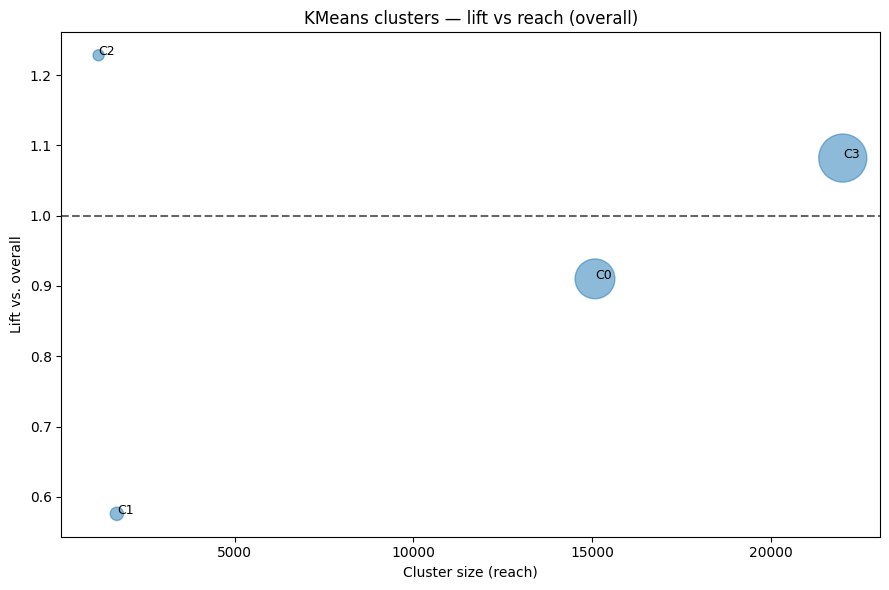

In [74]:
# step 18.3 — Bubble chart of clusters (overall)
import matplotlib.pyplot as plt

co = cluster_overall.sort_values("lift", ascending=False)
sizes = (co["n"] / co["n"].max()) * 1200

plt.figure(figsize=(9,6))
plt.scatter(co["n"], co["lift"], s=sizes, alpha=0.5)
for _, r in co.iterrows():
    plt.text(r["n"], r["lift"], f"C{int(r['cluster'])}", fontsize=9)
plt.axhline(1.0, color="k", ls="--", alpha=0.6)
plt.xlabel("Cluster size (reach)"); plt.ylabel("Lift vs. overall")
plt.title("KMeans clusters — lift vs reach (overall)")
plt.tight_layout(); plt.show()

In [75]:
# A) Full rule texts for transparency
import pandas as pd
pd.set_option("display.max_colwidth", None)

top_rules = seg_table.copy().sort_values(["test_lift","test_n"], ascending=[False, False])
display(top_rules[["segment","rule_text","test_n","test_rate","test_lift","test_precision_at_thresh","TP_at_thresh","FP_at_thresh"]].head(10))

,segment,rule_text,test_n,test_rate,test_lift,test_precision_at_thresh,TP_at_thresh,FP_at_thresh
0,Rule1,contact_unknown == 0 (not 'unknown') AND month_mar == 1 (is 'mar'),42,0.571429,7.895386,0.750000,6,2
1,Rule2,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 1 (is 'apr'),497,0.193159,2.668863,0.777778,14,4
2,Rule3,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance > 0.655,67,0.104478,1.443559,0.000000,0,0
3,Rule4,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 0 (not 'apr'),4877,0.074226,1.025575,0.500000,5,5
4,Rule5,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance <= 0.655,915,0.044809,0.619119,0.500000,1,1
5,Rule7,contact_unknown == 1 (is 'unknown') AND marital_married == 1 (is 'married') AND age > -0.417,1128,0.031915,0.440966,0.000000,0,0
6,Rule6,contact_unknown == 1 (is 'unknown') AND marital_married == 1 (is 'married') AND age <= -0.417,474,0.027426,0.378945,0.000000,0,0


In [76]:
# B) Per-cluster precision/TP/FP @ locked threshold on TEST (and overall optional)
import numpy as np, pandas as pd
from sklearn.metrics import precision_score

Xt_test  = pre.transform(X_test)
Xt_all   = pre.transform(X)

scores_test  = cal.predict_proba(X_test)[:,1]
predpos_test = (scores_test >= THRESH_SELECTED)

# KMeans labels already computed as labels_te / labels_all; if not, recompute:
try:
    labels_te
except NameError:
    labels_te = best_model.predict(Xt_test)
try:
    labels_all
except NameError:
    labels_all = best_model.predict(Xt_all)

rows = []
for c in sorted(np.unique(labels_te)):
    m = (labels_te == c)
    n = int(m.sum())
    if n == 0:
        continue
    y_true = y_test.values[m]
    y_hat  = predpos_test[m]
    tp = int(((y_true==1) & (y_hat==1)).sum())
    fp = int(((y_true==0) & (y_hat==1)).sum())
    prec = precision_score(y_true, y_hat, zero_division=0)
    rows.append({"cluster": int(c), "test_n": n, "test_tp": tp, "test_fp": fp, "precision@thresh": prec})
cluster_thresh = pd.DataFrame(rows).sort_values(["precision@thresh","test_n"], ascending=[False, False])
display(cluster_thresh)

,cluster,test_n,test_tp,test_fp,precision@thresh
2,2,242,1,0,1.000000
3,3,4358,17,5,0.772727
0,0,3031,8,6,0.571429
1,1,369,0,1,0.000000


In [77]:
# C) Export targets for Rule1/Rule2 and Cluster 2/3 at locked threshold
import numpy as np, pandas as pd

def mask_from_rule(Xt, conds, names):
    m = np.ones(Xt.shape[0], dtype=bool)
    for (fname, op, thr) in conds:
        j = names.index(fname)
        m &= (Xt[:, j] <= thr) if op == "<=" else (Xt[:, j] >  thr)
    return m

Xt_all = pre.transform(X)
scores_all = cal.predict_proba(X)[:,1]
predpos_all = scores_all >= THRESH_SELECTED

# ---- rules
exports = {}

for seg_name in ["Rule1","Rule2"]:
    if seg_name in seg_table["segment"].values:
        idx = int(seg_table.index[seg_table["segment"]==seg_name][0])
        conds = rules_df.loc[idx, "conditions"]
        m_rule = mask_from_rule(Xt_all, conds, feat_names)
        take = m_rule & predpos_all
        out = (X.loc[take, :].copy()
               .assign(model_score=scores_all[take],
                       segment=seg_name))
        out = out.sort_values("model_score", ascending=False)
        fname = f"targets_{seg_name.lower()}.csv"
        out.to_csv(fname, index=True)
        exports[fname] = len(out)

# ---- clusters
for c in [2,3]:
    m_cluster = (labels_all == c)
    take = m_cluster & predpos_all
    out = (X.loc[take, :].copy()
           .assign(model_score=scores_all[take],
                   segment=f"Cluster{c}"))
    out = out.sort_values("model_score", ascending=False)
    fname = f"targets_cluster{c}.csv"
    out.to_csv(fname, index=True)
    exports[fname] = len(out)

print("Saved files (rows):", exports)

Saved files (rows): {'targets_rule1.csv': 91, 'targets_rule2.csv': 182, 'targets_cluster2.csv': 38, 'targets_cluster3.csv': 311}


In [78]:
# D) Consolidated segment table (top rules + clusters)
# Merge rule segments and clusters with consistent columns
rules_ops = ops_segments.loc[:, ["Segment","Conditions","Test_N","Test_PosRate","Test_Lift",
                                 "Precision@Thresh","TP@Thresh","FP@Thresh"]].copy()
rules_ops["Type"] = "Rule"

# Per-cluster summary with threshold precision
co = cluster_overall.rename(columns={"n":"Overall_N","pos_rate":"Overall_PosRate","lift":"Overall_Lift"})
ct = cluster_test.rename(columns={"n":"Test_N","pos_rate":"Test_PosRate","lift":"Test_Lift"})
cc = pd.merge(ct, co[["cluster","Overall_N","Overall_PosRate","Overall_Lift"]], on="cluster", how="left")
cc = pd.merge(cc, cluster_thresh, on="cluster", how="left")
cc["Segment"] = cc["cluster"].map(lambda z: f"Cluster{z}")
cc["Type"] = "Cluster"
cc["Conditions"] = "(KMeans membership)"
cc.rename(columns={"precision@thresh":"Precision@Thresh",
                   "test_tp":"TP@Thresh", "test_fp":"FP@Thresh"}, inplace=True)

cols = ["Type","Segment","Conditions","Test_N","Test_PosRate","Test_Lift",
        "Precision@Thresh","TP@Thresh","FP@Thresh","Overall_N","Overall_PosRate","Overall_Lift"]
segment_summary = pd.concat([
    rules_ops.reindex(columns=cols, fill_value=np.nan),
    cc.reindex(columns=cols, fill_value=np.nan)
], ignore_index=True)

# Rank: prioritize high precision, then lift, then reach
segment_summary = segment_summary.sort_values(
    by=["Type","Precision@Thresh","Test_Lift","Test_N"], ascending=[True, False, False, False]
).reset_index(drop=True)

display(segment_summary)

,Type,Segment,Conditions,Test_N,Test_PosRate,Test_Lift,Precision@Thresh,TP@Thresh,FP@Thresh,Overall_N,Overall_PosRate,Overall_Lift
0,Cluster,Cluster2,(KMeans membership),242,0.090909,1.256084,1.000000,1,0,1192.0,0.088926,1.228262
1,Cluster,Cluster3,(KMeans membership),4358,0.078017,1.077961,0.772727,17,5,22020.0,0.078338,1.082015
2,Cluster,Cluster0,(KMeans membership),3031,0.067305,0.929942,0.571429,8,6,15085.0,0.065893,0.910128
3,Cluster,Cluster1,(KMeans membership),369,0.035230,0.486775,0.000000,0,1,1703.0,0.041691,0.575844
4,Rule,Rule2,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 1 (is 'apr'),497,0.193159,2.668863,0.777778,14,4,NaN,NaN,NaN
5,Rule,Rule1,contact_unknown == 0 (not 'unknown') AND month_mar == 1 (is 'mar'),42,0.571429,7.895386,0.750000,6,2,NaN,NaN,NaN
6,Rule,Rule4,contact_unknown == 0 (not 'unknown') AND month_mar == 0 (not 'mar') AND month_apr == 0 (not 'apr'),4877,0.074226,1.025575,0.500000,5,5,NaN,NaN,NaN
7,Rule,Rule5,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance <= 0.655,915,0.044809,0.619119,0.500000,1,1,NaN,NaN,NaN
8,Rule,Rule3,contact_unknown == 1 (is 'unknown') AND marital_married == 0 (not 'married') AND balance > 0.655,67,0.104478,1.443559,0.000000,0,0,NaN,NaN,NaN
9,Rule,Rule7,contact_unknown == 1 (is 'unknown') AND marital_married == 1 (is 'married') AND age > -0.417,1128,0.031915,0.440966,0.000000,0,0,NaN,NaN,NaN


In [80]:
cluster_feats

,cluster,top_features,top_deltas
0,0,"[age, marital_married, housing_no, education_primary, job_retired, marital_divorced, month_jun, month_aug, contact_telephone, job_housemaid]","[1.0130825231542793, 0.15395623135565129, 0.13229637885316542, 0.08441672190918131, 0.051512852171030826, 0.050917094796155124, 0.039687785880013274, 0.033231231355651314, 0.02868365097779251, 0.017571436857805763]"
1,1,"[campaign, day, month_aug, month_jul, housing_no, education_tertiary, month_jun, contact_telephone, job_management, job_technician]","[3.605823529991867, 0.7738853450652912, 0.19904367293012334, 0.14173311802701113, 0.10048140046975923, 0.05161746917204929, 0.05076332941867294, 0.041211641221374044, 0.038363211978860834, 0.03187087492660012]"
2,2,"[balance, age, month_nov, education_tertiary, job_management, loan_no, housing_no, marital_married, day, month_jun]","[4.147555108924523, 0.18993113501301145, 0.17598959731543626, 0.15944731543624158, 0.12387013422818793, 0.11033053691275174, 0.08903003355704697, 0.04806812080536915, 0.03454280280880917, 0.029301006711409408]"
3,3,"[marital_single, housing_yes, month_may, education_secondary, contact_cellular, education_tertiary, job_admin, job_services, job_technician, month_apr]","[0.1418076975476839, 0.1032213669391463, 0.07323496821071757, 0.04865365576748415, 0.025878428701180733, 0.017942643051771123, 0.015036716621253401, 0.01455699364214351, 0.014531062670299716, 0.014475068119891008]"


### RCOMMENDED SEGMENTATION

#### Persona A Known Contact

* Who: Customers with known contact (not “unknown”), can be targeted in the first half of the year espacialy in April and March.

* Why it works: Contactability + timing; aligns with model and real outcomes.

* How to target: Call/SMS (cellular first); use clear offer and quick CTA.

* Evidence (Rule 2): Test_N=497, 19.3% subscribe (2.67× lift), ~0.78 precision (14 TP / 4 FP).


#### Persona B  Affluent & Organized

* Who: Cluster 2 members (smaller but higher lift): over-index on higher balance, tertiary education, job_management, no personal loan, some Jun/Nov timing, often married.

* Why it works: Financial capacity + low competing debt + favorable timing pockets.

* How to target: Advisor-style call/SMS; highlight rate, safety, and laddering.

* Evidence (Cluster 2): Overall_N=1,192; Test_N=242; 9.1% subscribe (1.26× lift); precision 1.00 on the few predicted-positives in test (TP=1, FP=0—tiny volume at the current threshold).

#### Persona C  Young & Connected

* Who: Age ≤ 29, known contact (prefer cellular), avoid Jul/Aug.

* Why it works: Young decile’s observed rate ~12.1% (> baseline).

* How to target: SMS with simple, mobile flows; highlight low friction and example returns.

* Evidence: Age decile table; C3 over-indexes on contact_cellular, Apr/May, marital_single.

#### Persona D Seasoned Savers

* Who: Age 55+, known contact, no personal loan.

* Why it works: Slightly above baseline observed; “no personal loan” is a modest positive.

* How to target: Call/email; emphasize capital preservation and guaranteed income.

* Evidence: Age decile curve + loan status effects; elements appear in C2.

### Personas to Avoid (for now)

* Contact Unknown: All rule segments with contact_unknown=1 underperform, negligible yield at current threshold.

* Cluster 1: Low-yield pattern, Aug/Jul timing, and telephone contact → deprioritize.

In [81]:
print("duration in features?", "duration" in X.columns)

duration in features? False


In [82]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, balanced_accuracy_score
import numpy as np, pandas as pd

pipe = cal.estimator  # this is the plain Pipeline(pre -> XGB) we calibrated

scorers = {
    "accuracy": make_scorer(accuracy_score),
    "f1_pos":   make_scorer(f1_score, pos_label=1),
    "precision":make_scorer(precision_score, pos_label=1, zero_division=0),
    "recall":   make_scorer(recall_score, pos_label=1),
    "roc_auc":  make_scorer(roc_auc_score, needs_threshold=True),
    "pr_auc":   make_scorer(average_precision_score, needs_threshold=True),
    "bal_acc":  make_scorer(balanced_accuracy_score),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvres = cross_validate(pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1, return_train_score=False)

tbl = pd.DataFrame({m: [cvres[f'test_{m}'].mean(), cvres[f'test_{m}'].std()] for m in scorers}).T
tbl.columns = ["mean","std"]
print(tbl.sort_index())
print("\n✅ Target met?" , "≥81% accuracy" if tbl.loc["accuracy","mean"] >= 0.81 else "below 81% — see notes")


               mean       std
accuracy   0.867950  0.002207
bal_acc    0.588504  0.008123
f1_pos     0.222853  0.011707
pr_auc          NaN       NaN
precision  0.194137  0.008549
recall     0.261743  0.017741
roc_auc         NaN       NaN

✅ Target met? ≥81% accuracy
